In [1]:
!pip install fancyimpute catboost shap lime

#Libraries

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import ast
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.inspection import permutation_importance
from lime.lime_tabular import LimeTabularExplainer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import norm
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Open and load the file from Drive
directory = '/content/drive/MyDrive/Colab Notebooks/Project/'
# file_path = directory + 'Book2.csv'
# with open(file_path) as f:
#     data = pd.read_csv(f)

# data.info()
# data.head()

In [4]:
# file_path = directory + 'clean_data_mice_knn.xlsx'
directory = '/content/drive/MyDrive/Colab Notebooks/Project/'

file_path = directory + 'normalized_data.xlsx'

imputed_df = pd.read_excel(file_path)
imputed_df.info()
imputed_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Columns: 187 entries, Status to Val
dtypes: float64(185), int64(2)
memory usage: 137.5 KB


,Status,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,lysoPC a C20:4,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
0,1,1,0.135959,0.131794,0.026262,0.127203,0.275701,0.272440,0.083199,0.429530,...,0.646751,0.326418,0.339759,0.398522,0.403831,0.472296,0.595070,0.457642,0.355143,0.332584
1,1,0,0.147308,0.216408,0.016882,0.082599,0.099688,0.087231,0.173946,0.375323,...,0.348024,0.237898,0.296386,0.385753,0.366693,0.201055,0.313380,0.499563,0.446135,0.420225
2,0,0,0.457054,0.598087,0.075925,0.296256,1.000000,1.000000,0.237554,0.468250,...,0.688778,0.691563,0.672289,0.697581,0.759578,0.931398,1.000000,0.546725,0.726111,0.438202
3,0,0,0.022252,0.095006,0.015037,0.024229,0.009346,0.007585,0.038250,0.076923,...,0.520672,0.304288,0.325301,0.375000,0.585614,0.472296,0.556338,0.616594,0.421789,0.638202
4,0,0,0.015576,0.087648,0.000000,0.019824,0.034268,0.000000,0.065389,0.129066,...,0.000000,0.062241,0.006747,0.016129,0.126271,0.000000,0.005282,0.032314,0.024954,0.017978


In [5]:
imputed_df

,Status,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,lysoPC a C20:4,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
0,1,1,0.135959,0.131794,0.026262,0.127203,0.275701,0.272440,0.083199,0.429530,...,0.646751,0.326418,0.339759,0.398522,0.403831,0.472296,0.595070,0.457642,0.355143,0.332584
1,1,0,0.147308,0.216408,0.016882,0.082599,0.099688,0.087231,0.173946,0.375323,...,0.348024,0.237898,0.296386,0.385753,0.366693,0.201055,0.313380,0.499563,0.446135,0.420225
2,0,0,0.457054,0.598087,0.075925,0.296256,1.000000,1.000000,0.237554,0.468250,...,0.688778,0.691563,0.672289,0.697581,0.759578,0.931398,1.000000,0.546725,0.726111,0.438202
3,0,0,0.022252,0.095006,0.015037,0.024229,0.009346,0.007585,0.038250,0.076923,...,0.520672,0.304288,0.325301,0.375000,0.585614,0.472296,0.556338,0.616594,0.421789,0.638202
4,0,0,0.015576,0.087648,0.000000,0.019824,0.034268,0.000000,0.065389,0.129066,...,0.000000,0.062241,0.006747,0.016129,0.126271,0.000000,0.005282,0.032314,0.024954,0.017978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,0,1,0.368046,0.199853,0.049479,0.341410,0.389408,0.357775,0.146807,0.395973,...,0.245797,0.193638,0.205301,0.210349,0.263096,0.298153,0.190141,0.322271,0.191114,0.238202
90,0,1,0.568313,0.366320,0.051939,0.400881,0.523364,0.417193,0.178187,0.442437,...,0.659246,0.558783,0.696386,0.811828,0.876857,0.498681,0.517606,0.737991,0.659160,0.871910
91,0,1,0.425901,0.242159,0.045481,0.427313,0.582555,0.604298,0.262997,0.664430,...,0.484325,0.284924,0.416867,0.536290,0.517201,0.280211,0.345070,0.558079,0.264760,0.541573
92,0,1,0.350245,0.175940,0.041483,0.317181,0.274143,0.337547,0.148503,0.437274,...,0.457065,0.360996,0.455422,0.335349,0.869038,0.641161,0.669014,0.432314,0.446135,0.487640


#Filter rows where Status is "Prostate cancer" (1)

In [6]:
# imputed_df = shuffle(imputed_df, random_state=42)
# imputed_df.head()

In [7]:
df_race = imputed_df[imputed_df['Status'] == 1]
df_race.info()
df_race.head()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 0 to 83
Columns: 187 entries, Status to Val
dtypes: float64(185), int64(2)
memory usage: 64.6 KB


,Status,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,lysoPC a C20:4,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
0,1,1,0.135959,0.131794,0.026262,0.127203,0.275701,0.272440,0.083199,0.429530,...,0.646751,0.326418,0.339759,0.398522,0.403831,0.472296,0.595070,0.457642,0.355143,0.332584
1,1,0,0.147308,0.216408,0.016882,0.082599,0.099688,0.087231,0.173946,0.375323,...,0.348024,0.237898,0.296386,0.385753,0.366693,0.201055,0.313380,0.499563,0.446135,0.420225
5,1,1,0.283489,0.195254,0.050401,0.204846,0.398754,0.362832,0.198541,0.375323,...,0.543389,0.611342,0.412048,0.596774,0.632525,0.672823,0.609155,0.593013,0.939136,0.683146
13,1,0,0.483756,1.000000,0.797042,0.843612,0.155763,0.085967,0.064541,0.106866,...,0.552476,0.423237,0.518072,0.637097,0.689210,0.482850,0.359155,0.571179,0.586123,0.442697
14,1,0,0.354695,0.476685,0.055937,0.201542,0.454829,0.227560,0.351200,0.571502,...,0.681963,0.396957,0.556627,0.569892,0.521110,0.540897,0.313380,0.336245,0.482654,0.656180


In [8]:
file_path = directory + 'mrmr_race_results.xlsx'
mrmr_results = pd.read_excel(file_path)
mrmr_results.info()
mrmr_results.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   K                   91 non-null     int64  
 1   Accuracy            91 non-null     float64
 2   Feature_Rank        91 non-null     object 
 3   Feature_Importance  91 non-null     object 
 4   Selected_Features   91 non-null     object 
dtypes: float64(1), int64(1), object(3)
memory usage: 3.7+ KB


,K,Accuracy,Feature_Rank,Feature_Importance,Selected_Features
0,10,0.77778,"{'Thr': 1, 'Arg': 2, 'PC ae C44:4': 3, 'PC aa ...","{'Thr': 0.16507533242812936, 'Arg': 0.14755378...","['PC aa C28:1', 'DOPA', 'Thr', 'SM C18:1', 'Ar..."
1,11,0.88889,"{'PC ae C44:4': 1, 'SM C18:1': 2, 'Arg': 3, 'T...","{'PC ae C44:4': 0.14220337983082745, 'SM C18:1...","['PC aa C28:1', 'DOPA', 'Thr', 'SM C18:1', 'Ar..."
2,12,0.88889,"{'PC ae C44:4': 1, 'Arg': 2, 'Thr': 3, 'PC aa ...","{'PC ae C44:4': 0.1502902591696664, 'Arg': 0.1...","['PC aa C28:1', 'DOPA', 'Thr', 'SM C18:1', 'Ar..."
3,13,0.88889,"{'Thr': 1, 'PC ae C44:4': 2, 'Arg': 3, 'PC aa ...","{'Thr': 0.1392601244068044, 'PC ae C44:4': 0.1...","['PC aa C28:1', 'DOPA', 'Thr', 'SM C18:1', 'Ar..."
4,14,0.88889,"{'Thr': 1, 'PC ae C36:2': 2, 'PC aa C28:1': 3,...","{'Thr': 0.11793065849628918, 'PC ae C36:2': 0....","['PC aa C28:1', 'DOPA', 'Thr', 'SM C18:1', 'Ar..."


In [9]:
# Filter the DataFrame for K = 33
mrmr_33_features ={}
result_row = mrmr_results[mrmr_results['K'] == 33]

# Check if the result_row is not empty and retrieve the dictionary
if not result_row.empty:
    mrmr_33_features_str = result_row['Feature_Rank'].values[0]

    # Convert the string to a dictionary
    mrmr_33_features = ast.literal_eval(mrmr_33_features_str)

    print(mrmr_33_features)
else:
    print("No entry found for K = 33.")

print(f"Length of mrmr_33_features: {len(mrmr_33_features)}")

{'Met': 1, 'Thr': 2, 'PC ae C44:4': 3, 'PC ae C36:1': 4, 'Arg': 5, 'SM C20:2': 6, 'SM (OH) C14:1': 7, 'lysoPC a C16:1': 8, 'PC ae C44:5': 9, 'PC aa C32:2': 10, 'PC ae C36:2': 11, 'PC aa C38:4': 12, 'PC aa C36:6': 13, 'PC aa C36:5': 14, 'ADMA': 15, 'PC aa C28:1': 16, 'PC ae C30:2': 17, 'Tyr': 18, 'SM C18:1': 19, 'PC ae C30:0': 20, 'lysoPC a C20:4': 21, 'Kynurenine': 22, 'SM (OH) C16:1': 23, 'trans-OH-Pro': 24, 'SM (OH) C24:1': 25, 'PC ae C36:5': 26, 'PC aa C40:4': 27, 'PC ae C34:0': 28, 'C4': 29, 'PC aa C30:0': 30, 'Asp': 31, 'DOPA': 32, 'PEA': 33}
Length of mrmr_33_features: 33


In [10]:
# # Provided dictionaries
# dict1 = {'SM C20:2': 1, 'Thr': 2, 'Met': 3, 'PC ae C36:1': 4, 'ADMA': 5, 'PC aa C32:2': 6, 'PC ae C44:4': 7, 'Arg': 8, 'PC ae C44:5': 9, 'SM C24:1': 10, 'PC aa C36:5': 11, 'PC aa C28:1': 12, 'SM C18:1': 13, 'PC ae C30:0': 14, 'SM (OH) C14:1': 15, 'PC aa C36:6': 16, 'PC ae C36:2': 17, 'PC ae C36:5': 18, 'SM (OH) C16:1': 19, 'SM (OH) C24:1': 20, 'lysoPC a C16:1': 21, 'PC ae C34:0': 22, 'PC aa C30:0': 23, 'PC ae C30:2': 24, 'trans-OH-Pro': 25, 'Kynurenine': 26, 'lysoPC a C20:4': 27, 'PC aa C38:4': 28, 'PC ae C38:0': 29, 'PC aa C40:4': 30, 'Tyr': 31, 'C4': 32, 'Asp': 33, 'DOPA': 34, 'PEA': 35}

# dict2 = {'SM C20:2': 1, 'Thr': 2, 'Met': 3, 'PC ae C36:1': 4, 'ADMA': 5, 'PC aa C32:2': 6, 'PC ae C44:4': 7, 'Arg': 8, 'PC ae C44:5': 9, 'SM C24:1': 10, 'PC aa C36:5': 11, 'PC aa C28:1': 12, 'SM C18:1': 13, 'PC ae C30:0': 14, 'SM (OH) C14:1': 15, 'PC aa C36:6': 16, 'PC ae C36:2': 17, 'PC ae C36:5': 18, 'SM (OH) C16:1': 19, 'SM (OH) C24:1': 20, 'lysoPC a C16:1': 21, 'PC ae C34:0': 22, 'PC aa C30:0': 23, 'PC ae C30:2': 24, 'trans-OH-Pro': 25, 'Kynurenine': 26, 'lysoPC a C20:4': 27, 'PC aa C38:4': 28, 'PC ae C38:0': 29, 'PC aa C40:4': 30, 'Tyr': 31, 'C4': 32, 'Asp': 33, 'DOPA': 34, 'PEA': 35}

## dict1 = {'Met': 1, 'Thr': 2, 'PC ae C44:4': 3, 'PC ae C36:1': 4, 'Arg': 5, 'SM C20:2': 6, 'SM (OH) C14:1': 7, 'lysoPC a C16:1': 8, 'PC ae C44:5': 9, 'PC aa C32:2': 10, 'PC ae C36:2': 11, 'PC aa C38:4': 12, 'PC aa C36:6': 13, 'PC aa C36:5': 14, 'ADMA': 15, 'PC aa C28:1': 16, 'PC ae C30:2': 17, 'Tyr': 18, 'SM C18:1': 19, 'PC ae C30:0': 20, 'lysoPC a C20:4': 21, 'Kynurenine': 22, 'SM (OH) C16:1': 23, 'trans-OH-Pro': 24, 'SM (OH) C24:1': 25, 'PC ae C36:5': 26, 'PC aa C40:4': 27, 'PC ae C34:0': 28, 'C4': 29, 'PC aa C30:0': 30, 'Asp': 31, 'DOPA': 32, 'PEA': 33}

## dict2 = {'SM C20:2': 1, 'Thr': 2, 'Met': 3, 'PC ae C36:1': 4, 'ADMA': 5, 'PC aa C32:2': 6, 'PC ae C44:4': 7, 'Arg': 8, 'PC ae C44:5': 9, 'SM C24:1': 10, 'PC aa C36:5': 11, 'PC aa C28:1': 12, 'SM C18:1': 13, 'PC ae C30:0': 14, 'SM (OH) C14:1': 15, 'PC aa C36:6': 16, 'PC ae C36:2': 17, 'PC ae C36:5': 18, 'SM (OH) C16:1': 19, 'SM (OH) C24:1': 20, 'lysoPC a C16:1': 21, 'PC ae C34:0': 22, 'PC aa C30:0': 23, 'PC ae C30:2': 24, 'trans-OH-Pro': 25, 'Kynurenine': 26, 'lysoPC a C20:4': 27, 'PC aa C38:4': 28, 'PC ae C38:0': 29, 'PC aa C40:4': 30, 'Tyr': 31, 'C4': 32, 'Asp': 33, 'DOPA': 34, 'PEA': 35}

# # Check for differences
# differences = {key: (dict1[key], dict2[key]) for key in set(dict1) | set(dict2) if dict1.get(key) != dict2.get(key)}

# print(differences)

# # Convert the dictionaries to DataFrames
# df1 = pd.DataFrame(list(dict1.items()), columns=['Key', 'Value'])
# df2 = pd.DataFrame(list(dict2.items()), columns=['Key', 'Value'])

# # Print the result
# print("The two dictionaries are equal:", df1.equals(df2))

In [11]:
# dict1_unique = set(dict1.keys()) - set(dict2.keys())
# print(dict1_unique)

# dict2_unique = set(dict2.keys()) - set(dict1.keys())
# print(dict2_unique)

In [12]:
dict1 = {'Arg': 1, 'PC aa C28:1': 2, 'SM C18:1': 3, 'PC ae C36:1': 4, 'Thr': 5, 'PC ae C36:2': 6, 'trans-OH-Pro': 7, 'PC aa C30:0': 8, 'PC ae C44:4': 9, 'PC aa C36:5': 10, 'PC aa C38:4': 11, 'PC aa C36:6': 12, 'SM (OH) C16:1': 13, 'SM (OH) C14:1': 14, 'PC ae C34:0': 15, 'Tyr': 16, 'lysoPC a C16:1': 17, 'C4': 18, 'PC aa C40:4': 19, 'ADMA': 20, 'DOPA': 21}
dict2 = {'SM C20:2': 1, 'Thr': 2, 'Met': 3, 'PC ae C36:1': 4, 'ADMA': 5, 'PC aa C32:2': 6, 'PC ae C44:4': 7, 'Arg': 8, 'PC ae C44:5': 9, 'SM C24:1': 10, 'PC aa C36:5': 11, 'PC aa C28:1': 12, 'SM C18:1': 13, 'PC ae C30:0': 14, 'SM (OH) C14:1': 15, 'PC aa C36:6': 16, 'PC ae C36:2': 17, 'PC ae C36:5': 18, 'SM (OH) C16:1': 19, 'SM (OH) C24:1': 20, 'lysoPC a C16:1': 21, 'PC ae C34:0': 22, 'PC aa C30:0': 23, 'PC ae C30:2': 24, 'trans-OH-Pro': 25, 'Kynurenine': 26, 'lysoPC a C20:4': 27, 'PC aa C38:4': 28, 'PC ae C38:0': 29, 'PC aa C40:4': 30, 'Tyr': 31, 'C4': 32, 'Asp': 33, 'DOPA': 34, 'PEA': 35}

# Common keys
common_keys = set(dict1.keys()).intersection(dict2.keys())

# Keys unique to dict1
unique_dict1 = set(dict1.keys()).difference(dict2.keys())

# Keys unique to dict2
unique_dict2 = set(dict2.keys()).difference(dict1.keys())

print("Common ones ", common_keys)
print(len(common_keys))

print("\n unique_dict1", unique_dict1)

print("\n unique_dict2", unique_dict2)
print(len(unique_dict2))


Common ones  {'Thr', 'PC ae C34:0', 'Arg', 'lysoPC a C16:1', 'trans-OH-Pro', 'PC aa C30:0', 'PC aa C36:5', 'SM (OH) C14:1', 'PC ae C36:1', 'PC aa C38:4', 'PC aa C40:4', 'PC aa C28:1', 'SM C18:1', 'PC aa C36:6', 'DOPA', 'PC ae C44:4', 'C4', 'SM (OH) C16:1', 'PC ae C36:2', 'Tyr', 'ADMA'}
21

 unique_dict1 set()

 unique_dict2 {'PC ae C38:0', 'PC ae C44:5', 'SM C24:1', 'SM (OH) C24:1', 'Asp', 'PEA', 'PC aa C32:2', 'PC ae C30:2', 'PC ae C36:5', 'PC ae C30:0', 'SM C20:2', 'Kynurenine', 'lysoPC a C20:4', 'Met'}
14


In [13]:
dict1_keys = {'Arg': 1, 'PC aa C28:1': 2, 'SM C18:1': 3, 'PC ae C36:1': 4, 'Thr': 5, 'PC ae C36:2': 6, 'trans-OH-Pro': 7, 'PC aa C30:0': 8, 'PC ae C44:4': 9, 'PC aa C36:5': 10, 'PC aa C38:4': 11, 'PC aa C36:6': 12, 'SM (OH) C16:1': 13, 'SM (OH) C14:1': 14, 'PC ae C34:0': 15, 'Tyr': 16, 'lysoPC a C16:1': 17, 'C4': 18, 'PC aa C40:4': 19, 'ADMA': 20, 'DOPA': 21}
key_list = ['PC ae C36:5', 'Thr', 'Arg', 'trans-OH-Pro', 'PC aa C36:5', 'SM C24:1', 'Met', 'PC aa C32:2', 'PC ae C36:2', 'PC ae C36:1', 'Asp']

# Common keys
common_keys = set(dict1_keys.keys()).intersection(key_list)

common_keys


{'Arg', 'PC aa C36:5', 'PC ae C36:1', 'PC ae C36:2', 'Thr', 'trans-OH-Pro'}

In [14]:
# Get the list of columns from the dictionary
feature_columns = list(mrmr_33_features.keys())

# Create a list of columns to select (features + class column)
columns_to_select = ['Race'] + feature_columns

# Filter the DataFrame
df_33_features = df_race[columns_to_select]
features_33=df_33_features
df_33_features

,Race,Met,Thr,PC ae C44:4,PC ae C36:1,Arg,SM C20:2,SM (OH) C14:1,lysoPC a C16:1,PC ae C44:5,...,trans-OH-Pro,SM (OH) C24:1,PC ae C36:5,PC aa C40:4,PC ae C34:0,C4,PC aa C30:0,Asp,DOPA,PEA
0,1,0.326418,0.595070,0.036428,0.120338,0.681167,0.409821,0.244271,0.131794,0.267814,...,0.432394,0.220126,0.232263,0.215142,0.057598,0.233516,0.157329,0.054630,0.206782,0.00000
1,0,0.237898,0.313380,0.085762,0.149173,0.293623,0.354464,0.297917,0.216408,0.524964,...,0.251976,0.185776,0.210795,0.545741,0.050654,0.156201,0.250959,0.067596,0.428191,0.00000
5,1,0.611342,0.609155,0.078684,0.259131,0.757785,0.400000,0.383333,0.195254,0.418323,...,0.945267,0.166425,0.407074,0.559621,0.180556,0.093407,0.636224,0.098484,0.404255,0.00000
13,0,0.423237,0.359155,0.492090,0.047674,0.436480,0.110714,0.205208,1.000000,0.281629,...,0.324954,0.666183,0.026171,0.189905,0.423203,0.514129,0.591711,0.099203,0.398936,0.00000
14,0,0.396957,0.313380,0.056619,0.307958,0.401384,0.396429,0.544792,0.476685,0.301987,...,0.363471,0.400097,0.617665,0.699685,0.125817,0.248823,0.412126,0.182530,0.000000,0.00000
18,1,0.460581,0.507042,0.046211,0.148404,0.540287,0.294643,0.164583,0.191575,0.360155,...,0.393878,0.147073,0.396851,0.651735,0.084967,0.103611,0.350729,0.176783,0.400266,0.00000
19,1,0.414938,0.447183,0.057452,0.173395,0.649036,0.724107,0.372917,0.171342,0.369850,...,0.369552,0.162554,0.374361,0.704732,0.087418,0.128728,0.359939,0.086991,0.421543,0.00000
21,0,0.217151,0.422535,0.193589,1.000000,0.394958,0.142857,0.647917,0.462890,0.820650,...,0.308737,0.315433,0.443877,0.721136,0.191993,0.047881,1.000000,0.151641,0.000000,0.00000
23,0,0.284924,0.401408,0.292673,0.172241,0.271873,0.000000,0.094792,0.120758,0.184198,...,0.243868,0.057088,0.056635,0.298423,0.236111,1.000000,0.456639,0.108541,0.000000,0.00000
27,1,0.464730,0.830986,0.062032,0.143406,0.688581,0.466071,0.261458,0.253196,0.568589,...,0.691871,0.268021,0.333470,0.245426,0.097222,0.190738,0.240215,0.068314,0.000000,0.00000


In [15]:
# X = df_35_features.drop(columns=['Race'])
# y = df_35_features['Race']

X = df_33_features.drop(columns=['Race'])
y = df_33_features['Race']


print(X.shape, y.shape)
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print(X_test.shape, y_test.shape)

(44, 33) (44,)


#classifiers

In [16]:
# X_arr = np.array(X)
# y_arr = np.array(y)

##cross_validate_model

In [17]:
model_results = {}

def cross_validate_model(model, model_name, X, y, n_splits=5):
    global model_results

    X_arr = np.array(X)
    y_arr = np.array(y)

    # Initialize KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    confusion_matrices = []
    train_accuracies = []
    test_accuracies = []

    print(f"======={model_name}========")

    fold = 1
    for train_index, test_index in kf.split(X_arr):
        X_train, X_test = X_arr[train_index], X_arr[test_index]
        y_train, y_test = y_arr[train_index], y_arr[test_index]

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calculate confusion matrix for the test set of this fold
        cm = confusion_matrix(y_test, y_test_pred)
        confusion_matrices.append(cm)

        # Calculate and store training and testing accuracy
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Fold {fold} Confusion Matrix:\n{cm}")
        print(f"Fold {fold} Training Accuracy: {train_accuracy:.3f}")
        print(f"Fold {fold} Testing Accuracy: {test_accuracy:.3f}\n")

        fold += 1

    # Aggregate confusion matrices across folds
    total_cm = np.sum(confusion_matrices, axis=0)

    # Calculate average training and testing accuracy
    average_train_accuracy = np.mean(train_accuracies)
    average_test_accuracy = np.mean(test_accuracies)

    print("Aggregated Confusion Matrix:\n", total_cm)
    print(f"Average Training Accuracy: {average_train_accuracy:.3f}")
    print(f"Average Testing Accuracy: {average_test_accuracy:.3f}")

    result_dict = {
        'cm': total_cm,
        'train_accuracy': average_train_accuracy,
        'test_accuracy': average_test_accuracy
    }

    if model_name not in model_results:
        model_results[model_name] = []

    model_results[model_name].append(result_dict)

    return total_cm, average_train_accuracy, average_test_accuracy


##LogisticRegression

In [18]:
lr = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
print(lr.get_params())
cm_log, avg_train_acc_log, avg_test_acc_log = cross_validate_model(lr, "LogisticRegression", X, y)

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
=======LogisticRegression========
Fold 1 Confusion Matrix:
[[5 1]
 [0 3]]
Fold 1 Training Accuracy: 0.829
Fold 1 Testing Accuracy: 0.889

Fold 2 Confusion Matrix:
[[3 2]
 [1 3]]
Fold 2 Training Accuracy: 1.000
Fold 2 Testing Accuracy: 0.667

Fold 3 Confusion Matrix:
[[2 1]
 [1 5]]
Fold 3 Training Accuracy: 0.857
Fold 3 Testing Accuracy: 0.778

Fold 4 Confusion Matrix:
[[1 2]
 [1 5]]
Fold 4 Training Accuracy: 0.914
Fold 4 Testing Accuracy: 0.667

Fold 5 Confusion Matrix:
[[4 1]
 [0 3]]
Fold 5 Training Accuracy: 0.861
Fold 5 Testing Accuracy: 0.875

Aggregated Confusion Matrix:
 [[15  7]
 [ 3 19]]
Average Training Accuracy: 0.892
Average Testing Accuracy: 0.775


Logistic Regression with best params

In [19]:
# Parameter grid for hyperparameter tuning for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200, 500, 1000]
}

grid_search = GridSearchCV(estimator=LogisticRegression(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X, y)

best_logistic_model = grid_search.best_estimator_
print(best_logistic_model.get_params())

# best_logistic_model=LogisticRegression(C= 10, max_iter=500, solver='lbfgs', random_state=42)
# best_params_logistic= {'C': 100, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
# best_logistic_model = LogisticRegression(**best_params_logistic)

cm_log_best, avg_train_acc_log_best, avg_test_acc_log_best = cross_validate_model(best_logistic_model,"best_LogisticRegression", X,y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'C': 100, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
=======best_LogisticRegression========
Fold 1 Confusion Matrix:
[[6 0]
 [1 2]]
Fold 1 Training Accuracy: 1.000
Fold 1 Testing Accuracy: 0.889

Fold 2 Confusion Matrix:
[[3 2]
 [1 3]]
Fold 2 Training Accuracy: 1.000
Fold 2 Testing Accuracy: 0.667

Fold 3 Confusion Matrix:
[[3 0]
 [1 5]]
Fold 3 Training Accuracy: 1.000
Fold 3 Testing Accuracy: 0.889

Fold 4 Confusion Matrix:
[[3 0]
 [1 5]]
Fold 4 Training Accuracy: 1.000
Fold 4 Testing Accuracy: 0.889

Fold 5 Confusion Matrix:
[[5 0]
 [1 2]]
Fold 5 Training Accuracy: 1.000
Fold 5 Testing Accuracy: 0.875

Aggregated Confusion Matrix:
 [[20  2]
 [ 5 17]]
Average Training Accuracy: 1.000
Average Testing 

##Random Forest

In [20]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
print(rf.get_params())
cm_rf, avg_train_acc_rf, avg_test_acc_rf = cross_validate_model(rf, "RandomForestClassifier", X, y)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
=======RandomForestClassifier========
Fold 1 Confusion Matrix:
[[6 0]
 [1 2]]
Fold 1 Training Accuracy: 1.000
Fold 1 Testing Accuracy: 0.889

Fold 2 Confusion Matrix:
[[4 1]
 [0 4]]
Fold 2 Training Accuracy: 1.000
Fold 2 Testing Accuracy: 0.889

Fold 3 Confusion Matrix:
[[2 1]
 [1 5]]
Fold 3 Training Accuracy: 1.000
Fold 3 Testing Accuracy: 0.778

Fold 4 Confusion Matrix:
[[1 2]
 [2 4]]
Fold 4 Training Accuracy: 1.000
Fold 4 Testing Accuracy: 0.556

Fold 5 Confusion Matrix:
[[4 1]
 [1 2]]
Fold 5 Training Accuracy: 1.000
Fold 5 Testing Accuracy: 0.750

Aggregated Confusion Matrix:
 

In [21]:
# Parameter grid for hyperparameter tuning for Random forest
param_grid_rf = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 5, 10, 15],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid_rf,scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X, y)

# Best estimator from Grid Search
best_rf = grid_search.best_estimator_
print(best_rf.get_params())

# best_rf=RandomForestClassifier(max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=150, random_state=42)
# best_params_rf = {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
# best_rf = RandomForestClassifier(**best_params_rf)

cm_rf_best, avg_train_acc_rf_best, avg_test_acc_rf_best = cross_validate_model(best_rf,"best_RandomForestClassifier", X,y)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
=======best_RandomForestClassifier========
Fold 1 Confusion Matrix:
[[6 0]
 [1 2]]
Fold 1 Training Accuracy: 1.000
Fold 1 Testing Accuracy: 0.889

Fold 2 Confusion Matrix:
[[4 1]
 [0 4]]
Fold 2 Training Accuracy: 1.000
Fold 2 Testing Accuracy: 0.889

Fold 3 Confusion Matrix:
[[2 1]
 [2 4]]
Fold 3 Training Accuracy: 1.000
Fold 3 Testing Accuracy: 0.667

Fold 4 Confusion Matrix:
[[1 2]
 [2 4]]
Fold 4 Training Accuracy: 1.000
Fold 4 Testing Accuracy: 0.556

Fold 5 Confusion Matrix:
[[4 1]
 [0 3]]
Fold 5 Training Accura

##SVM

In [22]:
svm = SVC(kernel='linear', random_state=42, probability=True)
print(svm.get_params())
cm_svm, avg_train_acc_svm, avg_test_acc_svm = cross_validate_model(svm,"SVC",X,y)

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
=======SVC========
Fold 1 Confusion Matrix:
[[4 2]
 [0 3]]
Fold 1 Training Accuracy: 0.857
Fold 1 Testing Accuracy: 0.778

Fold 2 Confusion Matrix:
[[2 3]
 [1 3]]
Fold 2 Training Accuracy: 1.000
Fold 2 Testing Accuracy: 0.556

Fold 3 Confusion Matrix:
[[2 1]
 [1 5]]
Fold 3 Training Accuracy: 0.800
Fold 3 Testing Accuracy: 0.778

Fold 4 Confusion Matrix:
[[1 2]
 [1 5]]
Fold 4 Training Accuracy: 0.886
Fold 4 Testing Accuracy: 0.667

Fold 5 Confusion Matrix:
[[4 1]
 [0 3]]
Fold 5 Training Accuracy: 0.889
Fold 5 Testing Accuracy: 0.875

Aggregated Confusion Matrix:
 [[13  9]
 [ 3 19]]
Average Training Accuracy: 0.886
Average Testing Accuracy: 0.731


In [23]:
# Parameter grid for hyperparameter tuning for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
}

grid_search_svm = GridSearchCV(estimator=SVC(random_state=42, probability=True), param_grid=param_grid_svm, scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

grid_search_svm.fit(X, y)

# Best estimator from Grid Search
best_svm = grid_search_svm.best_estimator_
print(best_svm.get_params())


print("Best Estimator: ", best_svm)

# best_params_svm = {'C': 100, 'gamma': 'scale', 'kernel': 'linear', 'probability':True, 'random_state':42}
# best_svm = SVC(**best_params_svm)


cm_svm_best, avg_train_acc_svm_best, avg_test_acc_svm_best = cross_validate_model(best_svm,"best_SVM", X,y)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'C': 100, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Best Estimator:  SVC(C=100, kernel='linear', probability=True, random_state=42)
=======best_SVM========
Fold 1 Confusion Matrix:
[[6 0]
 [1 2]]
Fold 1 Training Accuracy: 1.000
Fold 1 Testing Accuracy: 0.889

Fold 2 Confusion Matrix:
[[3 2]
 [1 3]]
Fold 2 Training Accuracy: 1.000
Fold 2 Testing Accuracy: 0.667

Fold 3 Confusion Matrix:
[[3 0]
 [1 5]]
Fold 3 Training Accuracy: 1.000
Fold 3 Testing Accuracy: 0.889

Fold 4 Confusion Matrix:
[[3 0]
 [2 4]]
Fold 4 Training Accuracy: 1.000
Fold 4 Testing Accuracy: 0.778

Fold 5 Confusion Matrix:
[[5 0]
 [0 3]]
Fold 5 Training Accuracy: 1.000
Fold 5 Testing Accuracy: 1.000

Aggregated Confusion Matrix:
 [[20

##Decision Tree

In [24]:
dt = DecisionTreeClassifier(random_state=42)
print(dt.get_params())
cm_dt, avg_train_acc_dt, avg_test_acc_dt = cross_validate_model(dt,"DecisionTreeClassifier", X,y)

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
=======DecisionTreeClassifier========
Fold 1 Confusion Matrix:
[[5 1]
 [3 0]]
Fold 1 Training Accuracy: 1.000
Fold 1 Testing Accuracy: 0.556

Fold 2 Confusion Matrix:
[[2 3]
 [1 3]]
Fold 2 Training Accuracy: 1.000
Fold 2 Testing Accuracy: 0.556

Fold 3 Confusion Matrix:
[[0 3]
 [2 4]]
Fold 3 Training Accuracy: 1.000
Fold 3 Testing Accuracy: 0.444

Fold 4 Confusion Matrix:
[[1 2]
 [2 4]]
Fold 4 Training Accuracy: 1.000
Fold 4 Testing Accuracy: 0.556

Fold 5 Confusion Matrix:
[[2 3]
 [1 2]]
Fold 5 Training Accuracy: 1.000
Fold 5 Testing Accuracy: 0.500

Aggregated Confusion Matrix:
 [[10 12]
 [ 9 13]]
Average Training Accuracy: 1.000
Average Testing Accuracy: 0.522


In [25]:
# Parameter grid for hyperparameter tuning for Decision tree
param_grid_dt = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
}

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid_dt,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

grid_search.fit(X, y)

# Best estimator from Grid Search
best_dt = grid_search.best_estimator_
print(best_dt.get_params())

cm_dt_best, avg_train_acc_dt_best, avg_test_acc_dt_best = cross_validate_model(best_dt, "Best_DecisionTreeClassifier", X, y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
=======Best_DecisionTreeClassifier========
Fold 1 Confusion Matrix:
[[4 2]
 [3 0]]
Fold 1 Training Accuracy: 0.943
Fold 1 Testing Accuracy: 0.444

Fold 2 Confusion Matrix:
[[2 3]
 [0 4]]
Fold 2 Training Accuracy: 0.857
Fold 2 Testing Accuracy: 0.667

Fold 3 Confusion Matrix:
[[2 1]
 [1 5]]
Fold 3 Training Accuracy: 0.857
Fold 3 Testing Accuracy: 0.778

Fold 4 Confusion Matrix:
[[1 2]
 [2 4]]
Fold 4 Training Accuracy: 0.943
Fold 4 Testing Accuracy: 0.556

Fold 5 Confusion Matrix:
[[5 0]
 [0 3]]
Fold 5 Training Accuracy: 0.806
Fold 5 Testing Accuracy: 1.000

Aggregated Confusion Matrix:
 [[14  8]
 [ 6 16]]
Average Training Accura

##XGBoost

In [26]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
print(xgb_model.get_params())
cm_xgb, avg_train_acc_xgb, avg_test_acc_xgb = cross_validate_model(xgb_model,"XGBClassifier",X,y)

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}
=======XGBClassifier========
Fold 1 Confusion Matrix:
[[5 1]
 [2 1]]
Fo

In [27]:
# # Parameter grid for hyperparameter tuning for XGBoost
# param_grid_xgb = {
#     'n_estimators': [50, 100, 150, 200],
#     'max_depth': [3, 5, 7, 10],
#     'learning_rate': [0.01, 0.1],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'min_child_weight': [1, 3, 5]
# }

# grid_search = GridSearchCV(estimator=xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), param_grid=param_grid_xgb, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

# grid_search.fit(X, y)

# # Best estimator from Grid Search
# best_xgb = grid_search.best_estimator_
# print(best_xgb.get_params())

# cm_xgb_best, avg_train_acc_xgb_best, avg_test_acc_xgb_best = cross_validate_model(best_xgb, "Best_XGBoostClassifier", X, y)

**LGBM** causing error

In [28]:
# import lightgbm as lgb
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import classification_report, accuracy_score

# # Rename feature columns to avoid special characters
# X_train.columns = [col.replace(' ', '_') for col in X_train.columns]  # Example renaming
# X_test.columns = [col.replace(' ', '_') for col in X_test.columns]

# # Initialize the LightGBM Classifier
# lgb_model = lgb.LGBMClassifier(random_state=42, min_data_in_bin=1, min_data_in_leaf=1)

# # Fit the model
# lgb_model.fit(X_train, y_train)

# # Cross-validate with the best model
# cv_scores_lgb = cross_val_score(lgb_model, X, y, cv=5, scoring='accuracy')
# mean_cv_score_lgb = cv_scores_lgb.mean()

# # Make predictions on the test set
# y_pred_lgb = lgb_model.predict(X_test)

# # Generate the classification report
# report_lgb = classification_report(y_test, y_pred_lgb)

# # Calculate accuracy
# accuracy_lgb = accuracy_score(y_test, y_pred_lgb)

# # Print the results
# print("LightGBM Cross-Validation Scores: ", cv_scores_lgb)
# print("Mean Cross-Validation Accuracy: {:.2f}%".format(mean_cv_score_lgb * 100))
# print("LightGBM Classification Report:\n", report_lgb)
# print("LightGBM Accuracy: {:.2f}%".format(accuracy_lgb * 100))


##Naive Bayes

In [29]:
nb = GaussianNB()
print(nb.get_params())
cm_nb, avg_train_acc_nb, avg_test_acc_nb = cross_validate_model(nb,"NaiveBayes", X,y)

{'priors': None, 'var_smoothing': 1e-09}
=======NaiveBayes========
Fold 1 Confusion Matrix:
[[4 2]
 [0 3]]
Fold 1 Training Accuracy: 0.800
Fold 1 Testing Accuracy: 0.778

Fold 2 Confusion Matrix:
[[3 2]
 [0 4]]
Fold 2 Training Accuracy: 0.971
Fold 2 Testing Accuracy: 0.778

Fold 3 Confusion Matrix:
[[2 1]
 [2 4]]
Fold 3 Training Accuracy: 0.829
Fold 3 Testing Accuracy: 0.667

Fold 4 Confusion Matrix:
[[1 2]
 [2 4]]
Fold 4 Training Accuracy: 0.886
Fold 4 Testing Accuracy: 0.556

Fold 5 Confusion Matrix:
[[5 0]
 [1 2]]
Fold 5 Training Accuracy: 0.833
Fold 5 Testing Accuracy: 0.875

Aggregated Confusion Matrix:
 [[15  7]
 [ 5 17]]
Average Training Accuracy: 0.864
Average Testing Accuracy: 0.731


In [30]:
# Parameter grid for hyperparameter tuning for Naive bayes
param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Small values to add to the variance of each feature
}

grid_search = GridSearchCV(estimator=GaussianNB(),
                           param_grid=param_grid_nb,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

grid_search.fit(X, y)

# Best estimator from Grid Search
best_nb = grid_search.best_estimator_
print(best_nb.get_params())

cm_nb_best, avg_train_acc_nb_best, avg_test_acc_nb_best = cross_validate_model(best_nb, "Best_GaussianNB", X, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'priors': None, 'var_smoothing': 1e-08}
=======Best_GaussianNB========
Fold 1 Confusion Matrix:
[[4 2]
 [0 3]]
Fold 1 Training Accuracy: 0.800
Fold 1 Testing Accuracy: 0.778

Fold 2 Confusion Matrix:
[[3 2]
 [0 4]]
Fold 2 Training Accuracy: 0.943
Fold 2 Testing Accuracy: 0.778

Fold 3 Confusion Matrix:
[[2 1]
 [1 5]]
Fold 3 Training Accuracy: 0.800
Fold 3 Testing Accuracy: 0.778

Fold 4 Confusion Matrix:
[[1 2]
 [2 4]]
Fold 4 Training Accuracy: 0.886
Fold 4 Testing Accuracy: 0.556

Fold 5 Confusion Matrix:
[[4 1]
 [1 2]]
Fold 5 Training Accuracy: 0.833
Fold 5 Testing Accuracy: 0.750

Aggregated Confusion Matrix:
 [[14  8]
 [ 4 18]]
Average Training Accuracy: 0.852
Average Testing Accuracy: 0.728


##catboost

In [31]:
catboost = CatBoostClassifier(random_state=42, verbose=0, thread_count=-1)
print(catboost.get_params())
cm_catboost, avg_train_acc_catboost, avg_test_acc_catboost = cross_validate_model(catboost,"CatBoostClassifier",X,y)

{'verbose': 0, 'random_state': 42}
=======CatBoostClassifier========
Fold 1 Confusion Matrix:
[[5 1]
 [1 2]]
Fold 1 Training Accuracy: 1.000
Fold 1 Testing Accuracy: 0.778

Fold 2 Confusion Matrix:
[[2 3]
 [1 3]]
Fold 2 Training Accuracy: 1.000
Fold 2 Testing Accuracy: 0.556

Fold 3 Confusion Matrix:
[[2 1]
 [1 5]]
Fold 3 Training Accuracy: 1.000
Fold 3 Testing Accuracy: 0.778

Fold 4 Confusion Matrix:
[[1 2]
 [2 4]]
Fold 4 Training Accuracy: 1.000
Fold 4 Testing Accuracy: 0.556

Fold 5 Confusion Matrix:
[[3 2]
 [1 2]]
Fold 5 Training Accuracy: 1.000
Fold 5 Testing Accuracy: 0.625

Aggregated Confusion Matrix:
 [[13  9]
 [ 6 16]]
Average Training Accuracy: 1.000
Average Testing Accuracy: 0.658


In [32]:
# Parameter grid for hyperparameter tuning for CatBoost
param_grid_cb = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128],  # Number of splits for numeric features
}

catboost = CatBoostClassifier(random_state=42, verbose=0, thread_count=-1)

grid_search_cb = GridSearchCV(estimator=catboost,
                              param_grid=param_grid_cb,
                              scoring='accuracy',
                              cv=5,
                              verbose=2,
                              n_jobs=-1)

grid_search_cb.fit(X, y)

# Best estimator from Grid Search
best_cb = grid_search_cb.best_estimator_
print(best_cb.get_params())

# Cross-validate with the best CatBoost model
cm_catboost_best, avg_train_acc_catboost_best, avg_test_acc_catboost_best = cross_validate_model(best_cb, "Best_CatBoostClassifier", X, y)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
{'verbose': 0, 'random_state': 42, 'border_count': 64, 'depth': 7, 'iterations': 50, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
=======Best_CatBoostClassifier========
Fold 1 Confusion Matrix:
[[5 1]
 [1 2]]
Fold 1 Training Accuracy: 1.000
Fold 1 Testing Accuracy: 0.778

Fold 2 Confusion Matrix:
[[3 2]
 [0 4]]
Fold 2 Training Accuracy: 1.000
Fold 2 Testing Accuracy: 0.778

Fold 3 Confusion Matrix:
[[2 1]
 [1 5]]
Fold 3 Training Accuracy: 1.000
Fold 3 Testing Accuracy: 0.778

Fold 4 Confusion Matrix:
[[1 2]
 [2 4]]
Fold 4 Training Accuracy: 1.000
Fold 4 Testing Accuracy: 0.556

Fold 5 Confusion Matrix:
[[3 2]
 [1 2]]
Fold 5 Training Accuracy: 1.000
Fold 5 Testing Accuracy: 0.625

Aggregated Confusion Matrix:
 [[14  8]
 [ 5 17]]
Average Training Accuracy: 1.000
Average Testing Accuracy: 0.703


##knn

In [33]:
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
print(knn.get_params())
cm_knn, avg_train_acc_knn, avg_test_acc_knn = cross_validate_model(knn,"KNN",X,y)

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
=======KNN========
Fold 1 Confusion Matrix:
[[4 2]
 [0 3]]
Fold 1 Training Accuracy: 0.829
Fold 1 Testing Accuracy: 0.778

Fold 2 Confusion Matrix:
[[3 2]
 [1 3]]
Fold 2 Training Accuracy: 0.829
Fold 2 Testing Accuracy: 0.667

Fold 3 Confusion Matrix:
[[2 1]
 [1 5]]
Fold 3 Training Accuracy: 0.800
Fold 3 Testing Accuracy: 0.778

Fold 4 Confusion Matrix:
[[2 1]
 [1 5]]
Fold 4 Training Accuracy: 0.857
Fold 4 Testing Accuracy: 0.778

Fold 5 Confusion Matrix:
[[5 0]
 [1 2]]
Fold 5 Training Accuracy: 0.806
Fold 5 Testing Accuracy: 0.875

Aggregated Confusion Matrix:
 [[16  6]
 [ 4 18]]
Average Training Accuracy: 0.824
Average Testing Accuracy: 0.775


In [34]:
# Parameter grid for hyperparameter tuning for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10],  # Test small values for k
    'weights': ['uniform', 'distance'],  # Test different weighting schemes
    'metric': ['euclidean', 'manhattan'],  # Common distance metrics
    'p': [1, 2],  # Test Manhattan (p=1) vs Euclidean (p=2)
}

grid_search_knn = GridSearchCV(estimator=KNeighborsClassifier(),
                               param_grid=param_grid_knn,
                               scoring='accuracy',
                               cv=5,
                               verbose=2,
                               n_jobs=-1)

grid_search_knn.fit(X, y)

# Best estimator from Grid Search
best_knn = grid_search_knn.best_estimator_
print(best_knn.get_params())

cm_knn_best, avg_train_acc_knn_best, avg_test_acc_knn_best = cross_validate_model(best_knn, "Best_KNN", X, y)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
=======Best_KNN========
Fold 1 Confusion Matrix:
[[4 2]
 [0 3]]
Fold 1 Training Accuracy: 0.771
Fold 1 Testing Accuracy: 0.778

Fold 2 Confusion Matrix:
[[4 1]
 [1 3]]
Fold 2 Training Accuracy: 0.857
Fold 2 Testing Accuracy: 0.778

Fold 3 Confusion Matrix:
[[2 1]
 [1 5]]
Fold 3 Training Accuracy: 0.800
Fold 3 Testing Accuracy: 0.778

Fold 4 Confusion Matrix:
[[1 2]
 [1 5]]
Fold 4 Training Accuracy: 0.829
Fold 4 Testing Accuracy: 0.667

Fold 5 Confusion Matrix:
[[4 1]
 [1 2]]
Fold 5 Training Accuracy: 0.722
Fold 5 Testing Accuracy: 0.750

Aggregated Confusion Matrix:
 [[15  7]
 [ 4 18]]
Average Training Accuracy: 0.796
Average Testing Accuracy: 0.750


#Model Results

In [35]:
sorted_results = sorted(
    [
        (model_name, idx, result)
        for model_name, results in model_results.items()
        for idx, result in enumerate(results)
    ],
    key=lambda x: x[2]['test_accuracy'],  # Sort by test accuracy
    reverse=True  # Sort in descending order for highest accuracy first
)

print("\nSorted Model Results Summary:")
for model_name, idx, result in sorted_results:
    print(
        f"Model: {model_name} \n"
        f"CM: {result['cm']} \n"
        f"Training Accuracy: {result['train_accuracy']:.3f} \n"
        f"Testing Accuracy: {result['test_accuracy']:.3f}\n\n"
    )



Sorted Model Results Summary:
Model: best_SVM 
CM: [[20  2]
 [ 5 17]] 
Training Accuracy: 1.000 
Testing Accuracy: 0.844


Model: best_LogisticRegression 
CM: [[20  2]
 [ 5 17]] 
Training Accuracy: 1.000 
Testing Accuracy: 0.842


Model: best_RandomForestClassifier 
CM: [[17  5]
 [ 5 17]] 
Training Accuracy: 1.000 
Testing Accuracy: 0.775


Model: KNN 
CM: [[16  6]
 [ 4 18]] 
Training Accuracy: 0.824 
Testing Accuracy: 0.775


Model: LogisticRegression 
CM: [[15  7]
 [ 3 19]] 
Training Accuracy: 0.892 
Testing Accuracy: 0.775


Model: RandomForestClassifier 
CM: [[17  5]
 [ 5 17]] 
Training Accuracy: 1.000 
Testing Accuracy: 0.772


Model: Best_KNN 
CM: [[15  7]
 [ 4 18]] 
Training Accuracy: 0.796 
Testing Accuracy: 0.750


Model: SVC 
CM: [[13  9]
 [ 3 19]] 
Training Accuracy: 0.886 
Testing Accuracy: 0.731


Model: NaiveBayes 
CM: [[15  7]
 [ 5 17]] 
Training Accuracy: 0.864 
Testing Accuracy: 0.731


Model: Best_GaussianNB 
CM: [[14  8]
 [ 4 18]] 
Training Accuracy: 0.852 
Testing 

In [36]:
X = df_33_features.drop(columns=['Race'])
y = df_33_features['Race']
print(X.shape, y.shape)

(44, 33) (44,)


#Train best model

In [37]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_test.shape, y_test.shape)
print(X_train.shape, y_train.shape)

best_model = best_svm
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)

print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))
testing_accuracy = accuracy_score(y_test, y_test_pred)
training_accuracy = accuracy_score(y_train, y_train_pred)
print("Testing Accuracy: {:.2f}%".format(testing_accuracy * 100))
print("Training Accuracy: {:.2f}%".format(training_accuracy * 100))

(9, 33) (9,)
(35, 33) (35,)
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.67      0.80         3

    accuracy                           0.89         9
   macro avg       0.93      0.83      0.86         9
weighted avg       0.90      0.89      0.88         9

[[6 0]
 [1 2]]
Testing Accuracy: 88.89%
Training Accuracy: 100.00%


In [38]:
best_model.get_params()

{'C': 100,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': True,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

#P value

In [39]:
# # To get p-values, fit the model with statsmodels
# X_train_sm = sm.add_constant(X_train)
# # Add constant for intercept
# logit_model = sm.Logit(y_train, X_train_sm)
# result = logit_model.fit()
# model = sm.Logit(y_train, sm.add_constant(X_train)).fit()

# print(result.summary())

In [40]:
# print(X_train.shape, y_train.shape)
# corr_matrix = pd.DataFrame(X_train).corr().abs()

# # Select upper triangle of the correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# # Find features with high correlation (e.g., > 0.95)
# to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# # Debug: Print columns to drop
# print("Columns to drop due to high correlation:", to_drop)

# # Ensure that the columns to drop are present in X_train and X_test
# X_train_reduced = X_train.drop(columns=to_drop, errors='ignore')
# X_test_reduced = X_test.drop(columns=to_drop, errors='ignore')

# # Step 2: Check and Remove Features with High Variance Inflation Factor (VIF)
# X_train_reduced_sm = sm.add_constant(X_train_reduced)  # Add constant for intercept
# vif_data = pd.DataFrame()
# vif_data["VIF Factor"] = [variance_inflation_factor(X_train_reduced_sm.values, i) for i in range(X_train_reduced_sm.shape[1])]
# vif_data["features"] = X_train_reduced_sm.columns

# # Features with VIF > 10 are often considered highly collinear
# high_vif = vif_data[vif_data["VIF Factor"] > 10]["features"].tolist()

# # Debug: Print features with high VIF
# print("Features with high VIF:", high_vif)

# X_train_reduced_vif = X_train_reduced.drop(columns=high_vif, errors='ignore')
# X_test_reduced_vif = X_test_reduced.drop(columns=high_vif, errors='ignore')

# # Fit the Logistic Regression Model Using statsmodels for p-values
# X_train_reduced_vif_sm = sm.add_constant(X_train_reduced_vif)
# # Add constant for intercept
# logit_model = sm.Logit(y_train, X_train_reduced_vif_sm)

# # Fit the model and handle exceptions
# try:
#     result = logit_model.fit()

#     # Print the summary which includes p-values
#     print(result.summary())

#     # Extract p-values
#     p_values = result.pvalues
#     print("\nP-values for the features:\n", p_values)

# except Exception as e:
#     print("Error fitting model:", e)

# print("Shape of X_train_reduced_vif:", X_train_reduced_vif.shape)
# print("Shape of X_test_reduced_vif:", X_test_reduced_vif.shape)
# print("Shape of y_train:", y_train.shape)

# # # Train and Evaluate the Model with scikit-learn for Cross-Validation and Metrics
# # if X_train_reduced_vif.shape[1] > 0:  # Check if there are any features left
# #     logistic_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42, max_iter=1000)
# #     logistic_model.fit(X_train_reduced_vif, y_train)

# #     # Cross-validation scores
# #     cv_scores_logistic = cross_val_score(logistic_model, X_train_reduced_vif, y_train, cv=5, scoring='accuracy')
# #     mean_cv_score_logistic = cv_scores_logistic.mean()

# #     # Predictions and classification report
# #     y_pred_logistic = logistic_model.predict(X_test_reduced_vif)
# #     report_logistic = classification_report(y_test, y_pred_logistic)
# #     accuracy_logistic = accuracy_score(y_test, y_pred_logistic)

# #     # Print sklearn model results
# #     print("\nLogistic Regression Cross-Validation Scores:", cv_scores_logistic)
# #     print("Mean Cross-Validation Accuracy: {:.2f}%".format(mean_cv_score_logistic * 100))
# #     print("Logistic Regression Classification Report:\n", report_logistic)
# #     print("Logistic Regression Accuracy: {:.2f}%".format(accuracy_logistic * 100))
# # else:
# #     print("No features left to train the model after VIF reduction.")

In [41]:
# # Check the correlation matrix
# correlation_matrix = X_train_reduced.corr()
# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
# plt.title('Correlation Matrix')
# plt.show()

# # Calculate VIF for all features before dropping
# vif_data_all = pd.DataFrame()
# vif_data_all["Feature"] = X_train_reduced.columns
# vif_data_all["VIF"] = [variance_inflation_factor(X_train_reduced.values, i) for i in range(X_train_reduced.shape[1])]

# # Check the features in vif_data_all
# print("Features in VIF Data:\n", vif_data_all["Feature"].tolist())
# lenient_vif_threshold=825

# # Identify features with high VIF to drop based on the lenient threshold
# high_vif_features_lenient = vif_data_all[vif_data_all["VIF"] > lenient_vif_threshold]["Feature"].tolist()

# # Safely attempt to remove 'const' if it exists
# if 'const' in high_vif_features_lenient:
#     high_vif_features_lenient.remove('const')  # Exclude the constant

# # Drop features with high VIF from the training data
# X_train_reduced_vif_lenient = X_train_reduced.drop(columns=high_vif_features_lenient, errors='ignore')
# X_test_reduced_vif_lenient = X_test_reduced.drop(columns=high_vif_features_lenient, errors='ignore')

# # Check the shape of the reduced datasets with lenient threshold
# print("Shape of X_train_reduced_vif (lenient):", X_train_reduced_vif_lenient.shape)
# print("Shape of X_test_reduced_vif (lenient):", X_test_reduced_vif_lenient.shape)

# # Run logistic regression if there are features left
# if X_train_reduced_vif_lenient.shape[1] > 0:
#     logit_model_lenient = sm.Logit(y_train, sm.add_constant(X_train_reduced_vif_lenient))  # Add constant again for fitting
#     result_lenient = logit_model_lenient.fit()
#     print(result_lenient.summary())

# else:
#     print("No features left to train the model after lenient VIF reduction.")


In [42]:
# test = features_33
# print(test.shape)

# # Identify and remove constant or near-constant features
# threshold = 0.01  # This is the threshold for variance
# X = test.drop(columns=['Race'])  # Assuming 'Race' is your target variable

# # Remove constant features using VarianceThreshold
# var_thresh = VarianceThreshold(threshold=threshold)
# X_reduced = var_thresh.fit_transform(X)
# X = pd.DataFrame(X_reduced, columns=X.columns[var_thresh.get_support()])

# # Check how many features were dropped
# dropped_features = set(X.columns) - set(test.drop(columns=['Race']).columns)
# print("Dropped features due to low variance:", dropped_features)

# y = test['Race']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Add constant (intercept)
# X_train_const = sm.add_constant(X_train)

# # Fit the logistic regression model
# try:
#     logit_model = sm.Logit(y_train, X_train_const)
#     result = logit_model.fit()

#     # Print the summary which includes p-values
#     print(result.summary())

#     # Extracting p-values specifically
#     p_values = result.pvalues
#     print("P-values for the features:")
#     print(p_values)

# except Exception as e:
#     print(f"Error: {e}")


In [43]:
# y = test['Race']  # Dependent variable
# X = test.drop(columns=['Race'])  # Independent variables

# # Calculate VIF for the independent variables
# vif_data = pd.DataFrame()
# vif_data["Feature"] = X.columns
# vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# # Drop features with high VIF (e.g., VIF > 5)
# features_to_keep = vif_data[vif_data['VIF'] < 5]['Feature'].values
# X = X[features_to_keep]

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Fit the logistic regression model
# logit_model = sm.Logit(y_train, X_train)
# result = logit_model.fit()

# print(result.summary())

# # Check for convergence warnings and predictions
# if not result.converged:
#     print("Warning: The model did not converge.")

# # Make predictions
# predictions = result.predict(X_test)
# predicted_classes = np.where(predictions > 0.5, 1, 0)  # Adjust threshold as needed

# p_values = result.pvalues
# print("P-values for the features:")
# print(p_values)

In [44]:
# # Fit logistic regression using scikit-learn
# logistic_model = LogisticRegression()
# # logistic_model = LogisticRegression(penalty='l2')  # Use liblinear for L1

# # Define your dependent and independent variables
# y = test['Race']  # Dependent variable
# X = test.drop(columns=['Race'])  # Independent variables

# logistic_model.fit(X, y)

# # Get the coefficients
# coef = logistic_model.coef_[0]  # Coefficients for the features
# intercept = logistic_model.intercept_[0]  # Intercept term

# # Use statsmodels to get the standard errors
# # Add a constant to the feature set for statsmodels
# X_with_const = sm.add_constant(X)

# # Calculate predictions using the original model (no constant)
# predictions = logistic_model.predict(X)  # Use X without constant for predictions
# residuals = y - predictions

# # Calculate the variance and standard errors
# # Variance of residuals
# variance = np.var(residuals, ddof=1)

# # Use the design matrix for calculating standard errors
# # The design matrix must be for the original features without the constant added for fitting
# standard_errors = np.sqrt(np.diagonal(variance * np.linalg.inv(np.dot(X_with_const.T, X_with_const))))

# # Calculate z-values and p-values
# z_values = coef / standard_errors[1:]  # Exclude the first value (for the intercept)
# p_values = [2 * (1 - norm.cdf(np.abs(z))) for z in z_values]  # Use norm from scipy.stats

# # Create a DataFrame to display features and their corresponding p-values
# feature_names = X.columns if hasattr(X, 'columns') else [f'Feature {i}' for i in range(X.shape[1])]
# results_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Coefficient': coef,
#     'P-Value': p_values
# })

# # Create a DataFrame for the intercept
# intercept_df = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient': [intercept], 'P-Value': [None]})

# # Concatenate the intercept DataFrame to the results DataFrame
# results_df = pd.concat([results_df, intercept_df], ignore_index=True)

# print(results_df)
# print(X.shape, y.shape)

#p values for svc

In [45]:
# # Fit SVM model with RBF kernel
# svm_model = svm

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print(X_test.shape, y_test.shape)

# # svm_model.fit(X_train, y_train)

# # Calculate permutation feature importance
# perm_importance = permutation_importance(svm_model, X_test, y_test, n_repeats=30, random_state=42)

# # Create a DataFrame for the results
# perm_importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': perm_importance.importances_mean,
#     'Std': perm_importance.importances_std
# })

# # Sort by importance
# perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)

# print(perm_importance_df)

In [46]:
best_model

SVC(C=100, kernel='linear', probability=True, random_state=42)

# Using Lime to find Top Features

*run* this cell only once as it'll change the excel file

##Get the conditions for all 33 features for each instance

In [47]:
import pandas as pd
import os
from lime.lime_tabular import LimeTabularExplainer

# Define the directory and file path
directory = '/content/drive/MyDrive/Colab Notebooks/Project/'
file_path = os.path.join(directory, 'lime_results_svm_new.xlsx')


# Create a LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['EA', 'AA'],
    mode='classification'
)

indexes= X_test.shape[0]
instances = 15

# Loop over each index
for index in range(indexes):
    # Reset the instance counter for each index
    instance_id = 1

    # Generate 10 instances for each index
    for instance in range(instances):
        # Get the number of features in X_test
        num_features = X_test.shape[1]

        # Explain the instance
        exp = explainer.explain_instance(
            data_row=X_test.iloc[index].values,
            predict_fn=best_model.predict_proba,
            num_features=num_features
        )

        # LIME explanation dictionary with features and their importance scores
        feature_importance = exp.as_list()
        feature_importance_dict = {feature: round(importance, 5) for feature, importance in feature_importance}

        # Prepare data to be saved
        data = {
            'index': [index+1],
            'instance': [instance_id],
            'features': [feature_importance_dict]
        }
        df = pd.DataFrame(data)

        # Check if the file exists; if yes, append the data
        if os.path.exists(file_path):
            with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:
                df.to_excel(writer, index=False, header=False, startrow=writer.sheets['Sheet1'].max_row)
                print(f"Saved Index {index+1} : instance {instance_id} to Excel")
        else:
            # If the file does not exist, create it and write the DataFrame
            df.to_excel(file_path, index=False)
            print(f"Saved Index {index+1} : instance {instance_id} to Excel")

        # Increment instance ID for the next instance
        instance_id += 1


Saved Index 1 : instance 1 to Excel
Saved Index 1 : instance 2 to Excel
Saved Index 1 : instance 3 to Excel
Saved Index 1 : instance 4 to Excel
Saved Index 1 : instance 5 to Excel
Saved Index 1 : instance 6 to Excel
Saved Index 1 : instance 7 to Excel
Saved Index 1 : instance 8 to Excel
Saved Index 1 : instance 9 to Excel
Saved Index 1 : instance 10 to Excel
Saved Index 1 : instance 11 to Excel
Saved Index 1 : instance 12 to Excel
Saved Index 1 : instance 13 to Excel
Saved Index 1 : instance 14 to Excel
Saved Index 1 : instance 15 to Excel
Saved Index 2 : instance 1 to Excel
Saved Index 2 : instance 2 to Excel
Saved Index 2 : instance 3 to Excel
Saved Index 2 : instance 4 to Excel
Saved Index 2 : instance 5 to Excel
Saved Index 2 : instance 6 to Excel
Saved Index 2 : instance 7 to Excel
Saved Index 2 : instance 8 to Excel
Saved Index 2 : instance 9 to Excel
Saved Index 2 : instance 10 to Excel
Saved Index 2 : instance 11 to Excel
Saved Index 2 : instance 12 to Excel
Saved Index 2 : ins

##Get top N features for each instances

In [48]:
import pandas as pd
import os
import ast
from collections import defaultdict

key_counts = defaultdict(int)
top_10_features = defaultdict(int)

def top_N_features_for_all_instances(top_n=10):
    # Define the directory and file path
    directory = '/content/drive/MyDrive/Colab Notebooks/Project/'
    file_path = os.path.join(directory, 'lime_results_svm_new.xlsx')




    # Load the Excel file
    if os.path.exists(file_path):
        df = pd.read_excel(file_path)
        # df = df.dropna()

        total_rows = df.shape[0]
        print(f"Total number of rows: {total_rows}")

        # Loop through each row in the DataFrame
        for idx, row in df.iterrows():
            # Get the index and instance values from the DataFrame
            index_val = row['index']
            instance_val = row['instance']

            # Check if the 'features' cell is NaN and skip if it is
            features_instance_str = row['features']

            # Convert the string representation to a dictionary
            features_instance = ast.literal_eval(features_instance_str)

            # Get the top N keys
            top_keys = list(features_instance.keys())[:top_n]

            # Count the occurrences of each key in the top N
            for key in top_keys:
                key_counts[key] += 1

            # Optionally, print the top N keys for each instance
            print(f"\nTop {top_n} keys for Index {index_val}, Instance {instance_val}:")
            for position, key in enumerate(top_keys):
                print(f"{key} ==== Position: {position}")

        # Print the key counts across all instances
        print("\n" + "-" * 70 + "\n")
        print("Total occurrences of each key in the top 10 across all instances:")
        for key, count in key_counts.items():
            print(f"{key}: {count} times")

    else:
        print("The file does not exist.")

# Call the function to print the top keys for all instances and count their occurrences
top_N_features_for_all_instances(15)

Total number of rows: 135

Top 15 keys for Index 1, Instance 1:
PC ae C36:2 > 0.45 ==== Position: 0
PC aa C28:1 > 0.26 ==== Position: 1
SM (OH) C16:1 > 0.55 ==== Position: 2
SM C18:1 > 0.59 ==== Position: 3
PC ae C36:5 <= 0.29 ==== Position: 4
PC ae C36:1 > 0.27 ==== Position: 5
PC aa C36:5 <= 0.12 ==== Position: 6
lysoPC a C16:1 > 0.29 ==== Position: 7
SM C20:2 > 0.53 ==== Position: 8
SM (OH) C14:1 > 0.52 ==== Position: 9
lysoPC a C20:4 > 0.38 ==== Position: 10
PC ae C30:2 > 0.09 ==== Position: 11
0.35 < PC ae C44:5 <= 0.46 ==== Position: 12
DOPA <= 0.00 ==== Position: 13
0.27 < PC aa C32:2 <= 0.38 ==== Position: 14

Top 15 keys for Index 1, Instance 2:
PC ae C36:2 > 0.45 ==== Position: 0
PC aa C28:1 > 0.26 ==== Position: 1
SM C18:1 > 0.59 ==== Position: 2
SM (OH) C16:1 > 0.55 ==== Position: 3
PC ae C36:1 > 0.27 ==== Position: 4
PC ae C36:5 <= 0.29 ==== Position: 5
lysoPC a C16:1 > 0.29 ==== Position: 6
SM (OH) C14:1 > 0.52 ==== Position: 7
PC aa C36:5 <= 0.12 ==== Position: 8
lysoPC 

In [49]:
sorted_key_counts = dict(sorted(key_counts.items(), key=lambda item: item[1], reverse=True))
sorted_key_counts

{'PC ae C36:5 <= 0.29': 90,
 'PC ae C44:5 <= 0.35': 90,
 'Thr <= 0.37': 90,
 'PC aa C28:1 > 0.26': 75,
 'lysoPC a C20:4 > 0.38': 75,
 'Arg <= 0.37': 75,
 'SM (OH) C14:1 <= 0.28': 74,
 'DOPA <= 0.00': 72,
 'PC aa C36:5 <= 0.12': 60,
 'SM (OH) C14:1 > 0.52': 60,
 'SM (OH) C16:1 <= 0.32': 60,
 'Met <= 0.29': 60,
 'PC aa C32:2 > 0.53': 60,
 'PC ae C36:2 > 0.45': 45,
 'SM (OH) C16:1 > 0.55': 45,
 'PC ae C36:1 > 0.27': 45,
 'lysoPC a C16:1 > 0.29': 45,
 'SM C18:1 <= 0.39': 45,
 '0.26 < PC ae C36:2 <= 0.37': 45,
 '0.27 < PC aa C32:2 <= 0.38': 41,
 'trans-OH-Pro <= 0.31': 38,
 'SM C18:1 > 0.59': 30,
 'PC ae C30:2 > 0.09': 30,
 'PC aa C28:1 <= 0.16': 30,
 'PC ae C36:1 <= 0.15': 30,
 'PC ae C36:2 <= 0.26': 30,
 '0.16 < PC aa C28:1 <= 0.22': 30,
 'PC ae C36:5 > 0.44': 30,
 'C4 > 0.24': 30,
 '0.29 < Met <= 0.37': 29,
 '0.50 < Arg <= 0.62': 26,
 'lysoPC a C20:4 <= 0.23': 26,
 '0.12 < PC aa C36:5 <= 0.19': 26,
 'lysoPC a C16:1 <= 0.17': 24,
 '0.34 < PC aa C38:4 <= 0.44': 20,
 'SM C20:2 <= 0.29': 20,

In [50]:
file_path = os.path.join(directory, 'lime_top_features_svm_new.xlsx')

# Convert sorted_key_counts dictionary to a DataFrame
sorted_key_counts_df = pd.DataFrame(sorted_key_counts.items(), columns=['Condition', 'Count'])

# Save the DataFrame to an Excel file
sorted_key_counts_df.to_excel(file_path, index=False)

print(f"Data saved to {file_path}")

Data saved to /content/drive/MyDrive/Colab Notebooks/Project/lime_top_features_svm_new.xlsx


In [51]:
file_path = os.path.join(directory, 'lime_top_features_svm_new.xlsx')

data = pd.read_excel(file_path)
# Convert 'Condition' column to a list
lime_top_10 = data['Condition'].tolist()
data.head(20)

,Condition,Count
0,PC ae C36:5 <= 0.29,90
1,PC ae C44:5 <= 0.35,90
2,Thr <= 0.37,90
3,PC aa C28:1 > 0.26,75
4,lysoPC a C20:4 > 0.38,75
5,Arg <= 0.37,75
6,SM (OH) C14:1 <= 0.28,74
7,DOPA <= 0.00,72
8,PC aa C36:5 <= 0.12,60
9,SM (OH) C14:1 > 0.52,60


In [52]:
# Define the two lists
# list1 = [
#     "PC ae C36:5", "Thr", "Arg", "trans-OH-Pro", "PC aa C36:5",
#     "SM C24:1", "Met", "PC aa C32:2", "PC ae C36:2", "PC ae C36:1",
#     "Asp", "SM C18:1", "PEA", "PC aa C38:4"
# ]
list1 = [
    "PC ae C36:5", "Thr", "Arg", "trans-OH-Pro", "PC aa C36:5",
    "SM C24:1", "Met", "PC aa C32:2", "PC ae C36:2", "PC ae C36:1",
    "Asp"
]

list2 = [
    "SM (OH) C14:1", "Met", "lysoPC a C16:1", "DOPA", "PC ae C36:2",
    "PC ae C36:5", "PC aa C36:5", "C4", "SM C18:1", "Arg",
    "SM C20:2", "PC aa C28:1", "PC ae C44:5", "PC aa C32:2",
    "PC aa C38:4", "trans-OH-Pro", "SM (OH) C16:1", "Thr"
]

# Compute the common and unique items
common_items = set(list1) & set(list2)
unique_to_list1 = set(list1) - set(list2)
unique_to_list2 = set(list2) - set(list1)

# Print the results
print("Common Items:")
print(common_items)

print("\nUnique to List 1:")
print(unique_to_list1)

print("\nUnique to List 2:")
print(unique_to_list2)


Common Items:
{'PC ae C36:2', 'PC aa C36:5', 'PC ae C36:5', 'PC aa C32:2', 'Thr', 'Arg', 'Met', 'trans-OH-Pro'}

Unique to List 1:
{'SM C24:1', 'PC ae C36:1', 'Asp'}

Unique to List 2:
{'SM C20:2', 'SM (OH) C14:1', 'PC ae C44:5', 'SM C18:1', 'PC aa C38:4', 'DOPA', 'SM (OH) C16:1', 'C4', 'PC aa C28:1', 'lysoPC a C16:1'}


In [53]:
# Define the lists
list2 = [
    "SM (OH) C14:1", "Met", "lysoPC a C16:1", "DOPA", "PC ae C36:2",
    "PC ae C36:5", "PC aa C36:5", "C4", "SM C18:1", "Arg",
    "SM C20:2", "PC aa C28:1", "PC ae C44:5", "PC aa C32:2",
    "PC aa C38:4", "trans-OH-Pro", "SM (OH) C16:1", "Thr"
]

new_list = [
    "Met", "Thr", "PC ae C44:4", "PC ae C36:1", "Arg", "SM C20:2",
    "SM (OH) C14:1", "lysoPC a C16:1", "PC ae C44:5", "PC aa C32:2",
    "PC ae C36:2", "PC aa C38:4", "PC aa C36:6", "PC aa C36:5", "ADMA",
    "PC aa C28:1", "PC ae C30:2", "Tyr", "SM C18:1", "PC ae C30:0",
    "lysoPC a C20:4", "Kynurenine", "SM (OH) C16:1", "trans-OH-Pro",
    "SM (OH) C24:1", "PC ae C36:5", "PC aa C40:4", "PC ae C34:0", "C4",
    "PC aa C30:0", "Asp", "DOPA", "PEA"
]

print(len(new_list))

# Perform the comparison
common_items = set(list2) & set(new_list)
unique_to_list2 = set(list2) - set(new_list)
unique_to_new_list = set(new_list) - set(list2)

# Print the results
print("Common Items:")
print(common_items)
print(len(common_items))

print("\nUnique to List 2:")
print(unique_to_list2)

print("\nUnique to New List:")
print(unique_to_new_list)


33
Common Items:
{'PC ae C36:2', 'SM C20:2', 'PC aa C36:5', 'PC ae C36:5', 'SM (OH) C14:1', 'PC aa C32:2', 'SM C18:1', 'PC ae C44:5', 'PC aa C38:4', 'Thr', 'DOPA', 'Arg', 'Met', 'C4', 'PC aa C28:1', 'lysoPC a C16:1', 'trans-OH-Pro', 'SM (OH) C16:1'}
18

Unique to List 2:
set()

Unique to New List:
{'PC aa C30:0', 'PEA', 'PC ae C30:0', 'PC ae C44:4', 'PC ae C36:1', 'Kynurenine', 'PC ae C30:2', 'lysoPC a C20:4', 'PC aa C36:6', 'PC ae C34:0', 'SM (OH) C24:1', 'Tyr', 'PC aa C40:4', 'ADMA', 'Asp'}


# Train for all models

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

X = df_33_features.drop(columns=['Race'])
y = df_33_features['Race']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "lr": lr,
    "best_logistic_model": best_logistic_model,
    "rf": rf,
    "best_rf": best_rf,
    "svm": svm,
    "best_svm": best_svm,
    "dt": dt,
    "best_dt": best_dt,
    "xgb_model": xgb_model,
    "nb": nb,
    "best_nb": best_nb,
    "catboost": catboost,
    "best_catboost":best_cb,
    "knn": knn,
    "best_knn": best_knn
}

# Dictionary to store the results and trained models
trained_models = {}
new_results = {}

# Loop through the models dictionary
for model_name, model in models.items():
    print(f"\n\nTraining {model_name}...")
    model.fit(X_train, y_train)

    # Store the trained model
    trained_models[model_name] = model

    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Calculate performance metrics
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    training_accuracy = accuracy_score(y_train, y_train_pred)

    # Store results
    new_results[model_name] = {
        "Classification Report": classification_report(y_test, y_test_pred, output_dict=True),
        "Confusion Matrix": confusion_matrix(y_test, y_test_pred).tolist(),
        "Testing Accuracy": testing_accuracy,
        "Training Accuracy": training_accuracy
    }

    # Print results for this model
    print(classification_report(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred))
    print("Testing Accuracy: {:.2f}%".format(testing_accuracy * 100))
    print("Training Accuracy: {:.2f}%".format(training_accuracy * 100))

# Sort models based on testing accuracy
sorted_results = sorted(
    [
        (model_name, result)
        for model_name, result in new_results.items()
    ],
    key=lambda x: x[1]['Testing Accuracy'],  # Sort by testing accuracy
    reverse=True  # Sort in descending order for highest accuracy first
)

# Print sorted model results summary
print("\n\n\nSorted Model Results Summary:\n")
for model_name, result in sorted_results:
    print(
        f"Model: {model_name} \n"
        f"Confusion Matrix: {result['Confusion Matrix']} \n"
        f"Training Accuracy: {result['Training Accuracy']:.3f} \n"
        f"Testing Accuracy: {result['Testing Accuracy']:.3f}\n"
    )




Training lr...
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.75      1.00      0.86         3

    accuracy                           0.89         9
   macro avg       0.88      0.92      0.88         9
weighted avg       0.92      0.89      0.89         9

[[5 1]
 [0 3]]
Testing Accuracy: 88.89%
Training Accuracy: 82.86%


Training best_logistic_model...
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.67      0.80         3

    accuracy                           0.89         9
   macro avg       0.93      0.83      0.86         9
weighted avg       0.90      0.89      0.88         9

[[6 0]
 [1 2]]
Testing Accuracy: 88.89%
Training Accuracy: 100.00%


Training rf...
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.67   

In [83]:
# Accessing trained models outside the loop
for model_name, trained_model in trained_models.items():
    print(f"\nTrained Model: {model_name} => {trained_model}")


Trained Model: lr => LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)

Trained Model: best_logistic_model => LogisticRegression(C=100, random_state=42)

Trained Model: rf => RandomForestClassifier(n_jobs=-1, random_state=42)

Trained Model: best_rf => RandomForestClassifier(min_samples_split=10, random_state=42)

Trained Model: svm => SVC(kernel='linear', probability=True, random_state=42)

Trained Model: best_svm => SVC(C=100, kernel='linear', probability=True, random_state=42)

Trained Model: dt => DecisionTreeClassifier(random_state=42)

Trained Model: best_dt => DecisionTreeClassifier(max_features='sqrt', min_samples_leaf=4, random_state=42)

Trained Model: xgb_model => XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=

## shap figs

In [84]:
# import shap
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # Define a list of tree-based models for easier checking
# tree_models = ["rf", "best_rf", "xgb_model", "dt", "best_dt", "catboost"]

# # Loop through each model in the dictionary
# for model_name, best_model in trained_models.items():
#     print(f"Processing model: {model_name}")

#     print(f"Processing model: {model_name}")

#     # Check if the model is tree-based or linear and create the appropriate SHAP explainer
#     if model_name in tree_models:
#         # Use TreeExplainer for tree-based models
#         explainer = shap.TreeExplainer(best_model, X_train, check_additivity=False)
#     else:
#         # Use LinearExplainer for linear models (like Logistic Regression and SVM)
#         explainer = shap.Explainer(best_model, X_train)



#     # Calculate SHAP values for the test set
#     shap_values = explainer.shap_values(X_test)

#     # For tree-based models, shap_values will be a list of arrays (one for each class),
#     # so we need to pick the one for the model output we're interested in.
#     if isinstance(shap_values, list):
#         shap_values = shap_values[1]  # For binary classification, use the second class, adjust accordingly

#     # Compute mean absolute SHAP values for each feature
#     feature_importance = np.abs(shap_values).mean(axis=0)  # Now shap_values is an ndarray

#     # Create a DataFrame to store actual feature names and their corresponding SHAP importance
#     feature_names = X_train.columns  # Use actual feature names from the dataset
#     importance_df = pd.DataFrame({
#         "Feature": feature_names,
#         "SHAP Importance": feature_importance
#     })

#     # Sort features by importance and select the top 20
#     top_20_features = importance_df.sort_values(by="SHAP Importance", ascending=False).head(20)

#     # Print the ranking of the top 20 features
#     print(f"\nTop 20 Features for {model_name}:")
#     print(top_20_features)

#     # Visualization: SHAP summary plot for the top 20 features
#     shap.initjs()  # Initialize JavaScript for SHAP visualizations

#     # Get the indices of the top 20 features
#     top_20_indices = [list(feature_names).index(f) for f in top_20_features["Feature"]]

#     # SHAP summary plot for top 20 features
#     print("Variable Importance Plot - Global Interpretation")

#     # Use the top 20 features' indices to filter both shap_values and X_test
#     shap.summary_plot(shap_values[:, top_20_indices], X_test.iloc[:, top_20_indices],
#                       feature_names=top_20_features["Feature"].values, plot_type="bar", show=False)

#     # Adjust layout and display the plot
#     plt.tight_layout()
#     plt.show()

#     # Optionally save the summary plot for each model
#     plt.savefig(f"{model_name}_top_20_features_shap_plot.png")
#     plt.close()  # Close the plot to avoid overlap in the next iteration

In [85]:
print(X_test.shape, X_train.shape)

(9, 33) (35, 33)


In [86]:
# best_model =rf
# # Create a SHAP explainer without check_additivity
# explainer = shap.Explainer(best_model, X_train)  # No check_additivity here
# shap_values = explainer(X_test)

# # Compute mean absolute SHAP values for each feature
# feature_importance = np.abs(shap_values.values).mean(axis=0)

# # Create a DataFrame to store actual feature names and their corresponding SHAP importance
# feature_names = X_train.columns  # Use actual feature names from the dataset
# importance_df = pd.DataFrame({
#     "Feature": feature_names,
#     "SHAP Importance": feature_importance
# })

# # Sort features by importance and select the top 20
# top_20_features = importance_df.sort_values(by="SHAP Importance", ascending=False).head(20)

# # Print the ranking of the top 20 features
# print(f"\nTop 20 Features for {model_name}:")
# print(top_20_features)

# # Visualization: SHAP summary plot for the top 20 features
# shap.initjs()  # Initialize JavaScript for SHAP visualizations

# # Get the indices of the top 20 features
# top_20_indices = [list(feature_names).index(f) for f in top_20_features["Feature"]]

# # SHAP summary plot for top 20 features
# print("Variable Importance Plot - Global Interpretation")

# # Use the top 20 features' indices to filter both shap_values and X_test
# shap.summary_plot(shap_values[:, top_20_indices], X_test.iloc[:, top_20_indices],
#                   feature_names=top_20_features["Feature"].values, plot_type="bar", show=False)


## SelectKBest

In [88]:
# SelectKBest

from sklearn.feature_selection import SelectKBest, f_classif

# Dictionary to store feature selection results
feature_selection_results = {}

# Use SelectKBest to select top 20 features
selector = SelectKBest(score_func=f_classif, k=20)
selector.fit(X_train, y_train)

# Get selected features and scores
selected_features = X.columns[selector.get_support()].tolist()
feature_scores = selector.scores_

# Store the selected features and their scores
feature_selection_results["SelectKBest"] = {
    "Selected Features": selected_features,
    "Feature Scores": dict(zip(X.columns, feature_scores))
}

print("Top 20 features selected by SelectKBest:")
print(selected_features)


Top 20 features selected by SelectKBest:
['Thr', 'PC ae C44:4', 'Arg', 'SM C20:2', 'SM (OH) C14:1', 'lysoPC a C16:1', 'PC ae C44:5', 'PC aa C32:2', 'PC ae C36:2', 'PC aa C38:4', 'PC aa C36:6', 'PC aa C36:5', 'PC aa C28:1', 'PC ae C30:2', 'SM C18:1', 'lysoPC a C20:4', 'trans-OH-Pro', 'SM (OH) C24:1', 'PC ae C34:0', 'PC aa C30:0']


##T test

In [89]:
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Assuming df_33_features is your dataset and 'Race' is the grouping variable

# Separate the data into two groups based on 'Race'
group_0 = df_33_features[df_33_features['Race'] == 0]
group_1 = df_33_features[df_33_features['Race'] == 1]

# Initialize dictionaries to store results
results = {}
normality_results = {}
variance_results = {}

# For each metabolite (column), perform t-test, check normality and variance
for metabolite in df_33_features.columns[1:]:  # Exclude the 'Race' column
    # T-test
    t_stat, p_val = stats.ttest_ind(group_0[metabolite], group_1[metabolite])
    results[metabolite] = {'t_stat': t_stat, 'p_value': p_val}

    # Normality test (Shapiro-Wilk)
    stat_ea, p_val_ea = stats.shapiro(group_0[metabolite])
    stat_aa, p_val_aa = stats.shapiro(group_1[metabolite])
    normality_results[metabolite] = {'AA_p_value': p_val_aa, 'EA_p_value': p_val_ea}

    # Homogeneity of variance (Levene's test)
    stat, p_val_variance = stats.levene(group_0[metabolite], group_1[metabolite])
    variance_results[metabolite] = {'Levene_p_value': p_val_variance}

# Convert results to a DataFrame
results_df = pd.DataFrame(results).T
normality_df = pd.DataFrame(normality_results).T
variance_df = pd.DataFrame(variance_results).T

# Display the results for t-test, normality, and variance
print("T-test Results:\n", results_df)
print("\nNormality Test Results:\n", normality_df)
print("\nVariance Test Results:\n", variance_df)

# Collect all p-values for the t-tests and apply multiple testing correction
p_values = results_df['p_value'].values
_, corrected_p_values, _, _ = multipletests(p_values, method='bonferroni')

# Add corrected p-values to the results DataFrame
results_df['corrected_p_value'] = corrected_p_values

# Display the results with corrected p-values
print("\nResults with Bonferroni-corrected p-values:\n", results_df)


T-test Results:
                   t_stat   p_value
Met            -1.684829  0.099439
Thr            -2.093676  0.042365
PC ae C44:4     2.577860  0.013540
PC ae C36:1     1.922631  0.061325
Arg            -3.067428  0.003770
SM C20:2       -1.763444  0.085100
SM (OH) C14:1   2.433657  0.019282
lysoPC a C16:1  1.738512  0.089447
PC ae C44:5     1.758679  0.085917
PC aa C32:2     1.725694  0.091754
PC ae C36:2     2.220987  0.031799
PC aa C38:4    -2.142395  0.038004
PC aa C36:6     2.026390  0.049106
PC aa C36:5     1.583052  0.120912
ADMA           -1.488514  0.144086
PC aa C28:1     3.174305  0.002810
PC ae C30:2     1.902686  0.063952
Tyr            -1.644883  0.107459
SM C18:1       -2.143919  0.037874
PC ae C30:0     1.919280  0.061760
lysoPC a C20:4 -1.595727  0.118048
Kynurenine      1.156271  0.254105
SM (OH) C16:1   2.204538  0.033018
trans-OH-Pro   -2.393691  0.021224
SM (OH) C24:1   1.897445  0.064658
PC ae C36:5    -1.723480  0.092157
PC aa C40:4    -1.589373  0.119477
PC 

##Mann-Whitney U test

In [90]:
import pandas as pd
import scipy.stats as stats

# Assuming df_33_features is your DataFrame with 34 columns
# The first column is 'Race', followed by 33 metabolite/feature columns
# Example: df_33_features = pd.read_csv('your_data.csv')

# List of feature columns (33 metabolites/features)
feature_columns = df_33_features.columns[1:]  # Skipping the 'Race' column

# Initialize a dictionary to store the results
results = {
    'Feature': [],
    'Mann-Whitney U Stat': [],
    'Mann-Whitney p-value': [],
    'Welch\'s t-statistic': [],
    'Welch\'s p-value': []
}

# Loop over all features (metabolites)
for feature in feature_columns:
    # Extract AA and EA values for the current feature
    AA_group = df_33_features[df_33_features['Race'] == 1][feature].dropna()
    EA_group = df_33_features[df_33_features['Race'] == 0][feature].dropna()
    # print(AA_group.shape)

    # Mann-Whitney U test
    mann_whitney_stat, mann_whitney_p = stats.mannwhitneyu(AA_group, EA_group)

    # Welch's t-test
    t_stat, p_value = stats.ttest_ind(AA_group, EA_group, equal_var=False)

    # Append the results for the current feature
    results['Feature'].append(feature)
    results['Mann-Whitney U Stat'].append(mann_whitney_stat)
    results['Mann-Whitney p-value'].append(mann_whitney_p)
    results['Welch\'s t-statistic'].append(t_stat)
    results['Welch\'s p-value'].append(p_value)

# Convert the results into a DataFrame for easy visualization
results_df = pd.DataFrame(results)

# Display the results
results_df


,Feature,Mann-Whitney U Stat,Mann-Whitney p-value,Welch's t-statistic,Welch's p-value
0,Met,359.5,0.006022,1.684829,0.100395
1,Thr,342.5,0.018883,2.093676,0.042543
2,PC ae C44:4,120.0,0.004341,-2.577860,0.016331
3,PC ae C36:1,142.0,0.019507,-1.922631,0.063011
4,Arg,381.0,0.001149,3.067428,0.003916
5,SM C20:2,327.0,0.047287,1.763444,0.085432
6,SM (OH) C14:1,152.0,0.035646,-2.433657,0.020507
7,lysoPC a C16:1,188.5,0.213433,-1.738512,0.093354
8,PC ae C44:5,170.0,0.093267,-1.758679,0.086250
9,PC aa C32:2,174.5,0.115771,-1.725694,0.093690


In [91]:
# Filter for significant results (both tests p-value < 0.05)
significant_results = results_df[(results_df['Mann-Whitney p-value'] < 0.05) & (results_df["Welch's p-value"] < 0.05)]

# Display the significant metabolites/features
significant_results

,Feature,Mann-Whitney U Stat,Mann-Whitney p-value,Welch's t-statistic,Welch's p-value
1,Thr,342.5,0.018883,2.093676,0.042543
2,PC ae C44:4,120.0,0.004341,-2.577860,0.016331
4,Arg,381.0,0.001149,3.067428,0.003916
6,SM (OH) C14:1,152.0,0.035646,-2.433657,0.020507
10,PC ae C36:2,143.0,0.020743,-2.220987,0.035137
15,PC aa C28:1,115.0,0.002981,-3.174305,0.003923
23,trans-OH-Pro,344.5,0.016649,2.393691,0.021491


In [92]:
import pandas as pd
from statsmodels.stats.multitest import multipletests

# Assuming results_df is your DataFrame containing the p-values
# Combine the p-values from both tests (Mann-Whitney and Welch's t-test)
combined_p_values = pd.concat([results_df['Mann-Whitney p-value'], results_df["Welch's p-value"]], ignore_index=True)

# Apply Benjamini-Hochberg (FDR) correction
rejected, corrected_p_values, _, _ = multipletests(combined_p_values, alpha=0.05, method='fdr_bh')

# Add the corrected p-values back to the DataFrame
results_df['Corrected p-value (Mann-Whitney)'] = corrected_p_values[:len(results_df)]
results_df["Corrected p-value (Welch's t-test)"] = corrected_p_values[len(results_df):]

# Filter for significant results (corrected p-value < 0.05)
significant_results = results_df[(results_df['Corrected p-value (Mann-Whitney)'] < 0.05) & (results_df["Corrected p-value (Welch's t-test)"] < 0.05)]

# Display the significant metabolites/features
significant_results


,Feature,Mann-Whitney U Stat,Mann-Whitney p-value,Welch's t-statistic,Welch's p-value,Corrected p-value (Mann-Whitney),Corrected p-value (Welch's t-test)
4,Arg,381.0,0.001149,3.067428,0.003916,0.044074,0.044074
15,PC aa C28:1,115.0,0.002981,-3.174305,0.003923,0.044074,0.044074


In [93]:
print(X.shape, y.shape)

(44, 33) (44,)


##permutation_importance

In [94]:
from collections import Counter
from sklearn.inspection import permutation_importance

# Dictionary to store permutation importance results
permutation_results = {}
top_n_features = 15

# Counter to track feature occurrences in the top 20 lists for all models
feature_counter_all_models = Counter()

# Counter to track feature occurrences in the top 20 lists for selected models
selected_models = ["best_logistic_model", "best_rf", "best_svm"]
feature_counter_selected_models = Counter()

for model_name, model in trained_models.items():
    print(f"\nCalculating Permutation Importance for {model_name}...")

    # Perform permutation importance
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

    # Get top 20 features based on mean importance
    importance_scores = result.importances_mean
    sorted_indices = importance_scores.argsort()[::-1][:top_n_features]
    top_features = X.columns[sorted_indices].tolist()

    # Update feature counters
    feature_counter_all_models.update(top_features)

    # If the model is in the selected models list, update the selected feature counter
    if model_name in selected_models:
        feature_counter_selected_models.update(top_features)

    # Store results for the current model
    permutation_results[model_name] = {
        "Top Features": top_features,
        "Importance Scores": importance_scores[sorted_indices].tolist()
    }

    print(f"Top 20 features for {model_name}: {top_features}")

# Summarize feature occurrences across all models (Top n features)
print(f"\nFeature Occurrences Across All Models (Top {top_n_features}):")
for feature, count in feature_counter_all_models.most_common():
    print(f"{feature}: {count}")

# Summarize feature occurrences across selected models (Top n features)
print(f"\nFeature Occurrences Across Selected Models (Top {top_n_features}):")
for feature, count in feature_counter_selected_models.most_common():
    print(f"{feature}: {count}")



Calculating Permutation Importance for lr...
Top 20 features for lr: ['SM (OH) C14:1', 'PC ae C36:2', 'SM (OH) C16:1', 'Arg', 'lysoPC a C16:1', 'PC ae C36:5', 'trans-OH-Pro', 'PC ae C36:1', 'PC aa C40:4', 'PC aa C32:2', 'PC ae C44:5', 'Tyr', 'PEA', 'PC aa C36:5', 'SM C20:2']

Calculating Permutation Importance for best_logistic_model...
Top 20 features for best_logistic_model: ['PC ae C36:2', 'SM (OH) C14:1', 'Arg', 'SM C18:1', 'PC aa C28:1', 'PC ae C44:5', 'PC ae C36:5', 'PC aa C32:2', 'lysoPC a C16:1', 'C4', 'PC aa C38:4', 'PC ae C30:2', 'SM (OH) C16:1', 'PC aa C36:5', 'SM C20:2']

Calculating Permutation Importance for rf...
Top 20 features for rf: ['PC ae C36:2', 'PC ae C36:1', 'Arg', 'Thr', 'SM C18:1', 'PC ae C30:0', 'SM (OH) C14:1', 'PC ae C36:5', 'lysoPC a C16:1', 'PC aa C36:6', 'PC aa C38:4', 'PEA', 'PC aa C32:2', 'PC ae C44:5', 'ADMA']

Calculating Permutation Importance for best_rf...
Top 20 features for best_rf: ['PC ae C36:2', 'PC ae C36:1', 'Arg', 'PEA', 'DOPA', 'PC ae C4

##LASSO feature selection

In [95]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# # Scale the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Train Lasso model
lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X, y)

# Get selected features
lasso_features = X.columns[lasso.coef_ != 0]
print("Features selected by Lasso:", lasso_features.tolist())


Features selected by Lasso: ['Thr', 'Arg', 'SM (OH) C14:1', 'PC aa C32:2', 'PC ae C36:2', 'PC aa C36:5', 'ADMA', 'PC aa C28:1', 'SM C18:1', 'trans-OH-Pro', 'PC aa C40:4', 'C4']


##SHAP for all models

In [96]:
output_dir = directory + "race_shap_plots"
os.makedirs(output_dir, exist_ok=True)

# Model to skip
tree_based_models = ["xgb_model"]
feature_names = [col for col in X_test.columns if col != "Race"]
# filtered_trained_models = {model_name: trained_model for model_name, trained_model in trained_models.items() if model_name not in tree_based_models}

np.random.seed(42)

# for model_name, trained_model in filtered_trained_models.items():


for model_name, trained_model in trained_models.items():

    print(f"\n\nFor {model_name}")
    print(f"Model: {model_name}, Object ID: {id(trained_model)}")


    if model_name in tree_based_models:
        # Create a SHAP explainer for tree-based models (XGBoost)
        explainer = shap.TreeExplainer(trained_model)
        # shap_values = explainer.shap_values(X_test)

    else:
        # Create a SHAP explainer for non-tree models
        explainer = shap.KernelExplainer(trained_model.predict, X_train)
        # shap_values = explainer.shap_values(X_test)


    shap_values = explainer(X_test)

    print(shap_values)
    # print(shap_values.shape)
    # print(shap_values[0].shape)
    # print(shap_values[1].shape)

    # Initialize JS visualization for interactive plots
    shap.initjs()

    # Print a message for the global interpretation
    print(f"{model_name} - Variable Importance Plot")

    # Create the SHAP summary plot for global model interpretation
    shap.summary_plot(shap_values, feature_names=feature_names, plot_type='bar', show=False, max_display=15)

    # # Adjust layout and display the plot
    # plt.tight_layout()
    # plt.show()


    output_path = os.path.join(output_dir, f"race_{model_name}_shap.png")
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved SHAP summary plot for {model_name} to {output_path}\n\n")

    # Clear the current plot to avoid overlap in subsequent iterations
    plt.clf()
    print(100*"=")

Output hidden; open in https://colab.research.google.com to view.

#Train best model

In [97]:
best_model.get_params()

{'C': 100,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': True,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

# Odd ratios for each feature

In [98]:
# # Odds ratios for each feature
# odds_ratios = np.exp(best_model.coef_[0])
# feature_importance = pd.DataFrame({
#     'Feature': X_train.columns,
#     'Coefficient': best_model.coef_[0],
#     'Odds Ratio': odds_ratios
# }).sort_values(by="Odds Ratio", ascending=False)

# print(feature_importance)

#Explainable AI

##SHAP

  0%|          | 0/9 [00:00<?, ?it/s]

SVC(C=100, kernel='linear', probability=True, random_state=42) - Variable Importance Plot


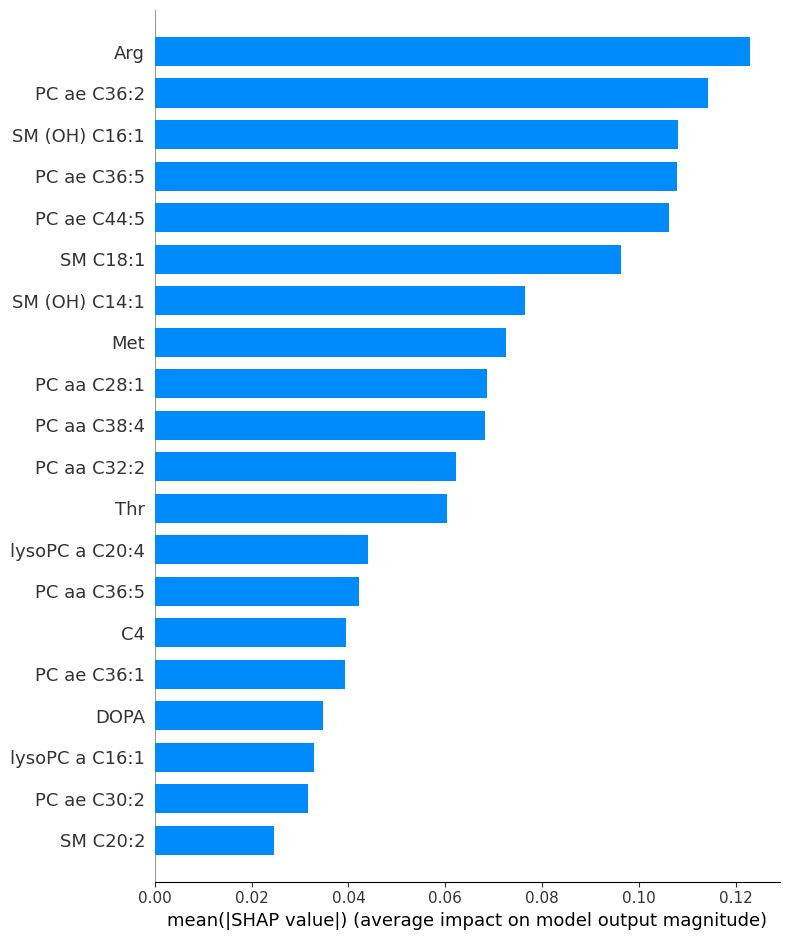

In [99]:
# Create a SHAP explainer
# explainer = shap.Explainer(best_model, X_train)
# shap_values = explainer(X_test)

explainer = shap.KernelExplainer(best_model.predict, X_train)

# shap_values = explainer.shap_values(X_test)
shap_values = explainer(X_test)

# Plot SHAP values for the first instance in the test set
shap.initjs()
print(f"{best_model} - Variable Importance Plot")
shap.summary_plot(shap_values, feature_names=feature_names, plot_type='bar', show=False)
plt.tight_layout()
plt.show()

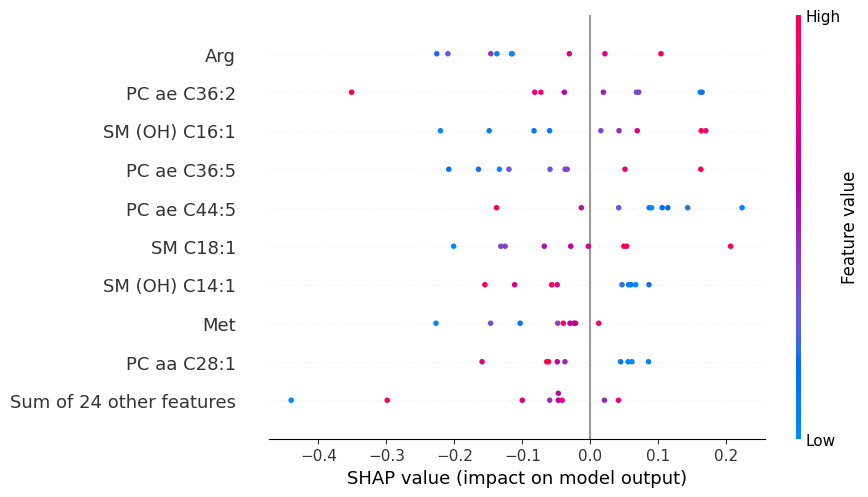

In [100]:
# Beeswarm
shap.plots.beeswarm(shap_values)

In [101]:
# Force plot for a specific instance in the test set
index = 0
print(f"Force Plot for Test Instance at Index {index}")
shap.initjs()
shap.plots.force(shap_values[index])

Force Plot for Test Instance at Index 0


In [102]:
shap_values_df = pd.DataFrame(shap_values.values, columns=X_test.columns)

print(shap_values_df.iloc[:, :20])
print(shap_values_df.iloc[:, -15:])

        Met       Thr  PC ae C44:4  PC ae C36:1       Arg  SM C20:2  \
0 -0.021744 -0.008788    -0.008004    -0.058753 -0.030848 -0.054860   
1 -0.146741 -0.121045     0.016448     0.054213 -0.209612  0.023450   
2 -0.103253 -0.066618     0.006818    -0.005931 -0.114763  0.021350   
3 -0.029878  0.008039    -0.009042    -0.039894 -0.116015  0.005177   
4 -0.227061 -0.120873     0.021272     0.061401 -0.225976  0.028905   
5 -0.024050 -0.056757     0.020487     0.033701  0.021494  0.008408   
6 -0.039724 -0.115916     0.015193    -0.075074 -0.146479  0.010858   
7  0.012442 -0.027758     0.003219     0.013100  0.103968  0.005065   
8 -0.047955 -0.016841    -0.042980     0.011768 -0.137498  0.062687   

   SM (OH) C14:1  lysoPC a C16:1  PC ae C44:5  PC aa C32:2  PC ae C36:2  \
0      -0.155109       -0.035353     0.041775     0.015595    -0.351262   
1       0.046682        0.000000     0.105709     0.018828     0.067797   
2      -0.048776        0.043552    -0.013177     0.008708    -0

In [103]:
shap_values_df.columns

Index(['Met', 'Thr', 'PC ae C44:4', 'PC ae C36:1', 'Arg', 'SM C20:2',
       'SM (OH) C14:1', 'lysoPC a C16:1', 'PC ae C44:5', 'PC aa C32:2',
       'PC ae C36:2', 'PC aa C38:4', 'PC aa C36:6', 'PC aa C36:5', 'ADMA',
       'PC aa C28:1', 'PC ae C30:2', 'Tyr', 'SM C18:1', 'PC ae C30:0',
       'lysoPC a C20:4', 'Kynurenine', 'SM (OH) C16:1', 'trans-OH-Pro',
       'SM (OH) C24:1', 'PC ae C36:5', 'PC aa C40:4', 'PC ae C34:0', 'C4',
       'PC aa C30:0', 'Asp', 'DOPA', 'PEA'],
      dtype='object')

In [104]:
shap_values_array = shap_values.values
print(shap_values_array)

[[-0.02174403 -0.00878825 -0.0080037  -0.05875326 -0.03084849 -0.05486035
  -0.15510897 -0.03535349  0.04177541  0.01559517 -0.35126164 -0.05098185
   0.00057293  0.05797744 -0.00966166 -0.03733687 -0.01101901  0.01287522
   0.05345848  0.00746709  0.02334429  0.00554282  0.16991064  0.02354621
   0.00132335 -0.16458923  0.00779657  0.00330521  0.00284418 -0.00814879
   0.01414258  0.02212484  0.        ]
 [-0.14674108 -0.12104533  0.01644755  0.05421319 -0.20961207  0.02344998
   0.0466819   0.          0.10570907  0.01882815  0.06779685 -0.08229753
   0.          0.07043396  0.00601988  0.06123671  0.00542568  0.00549325
  -0.13165201  0.          0.01422723 -0.00621073 -0.14877229  0.04978753
  -0.01152701 -0.20826382  0.         -0.01422766  0.01151535 -0.01977388
   0.          0.          0.        ]
 [-0.10325251 -0.06661837  0.00681798 -0.00593085 -0.11476263  0.0213505
  -0.04877617  0.04355228 -0.01317698  0.00870784 -0.08174106 -0.04919005
   0.          0.0141177  -0.017658

##LIME

In [105]:
np.random.seed(42)

# Create a LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['EA', 'AA'],
    mode='classification'
)

# Index of the instance to explain
instance_index = 4
num_features = 10
exp = explainer.explain_instance(
    data_row=X_test.iloc[instance_index].values,
    predict_fn=best_model.predict_proba,
    num_features=num_features
)

# Show the explanation
exp.show_in_notebook(show_table=True)

In [106]:
import numpy as np
from lime.lime_tabular import LimeTabularExplainer

# Ensure reproducibility
np.random.seed(42)

# Create a LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['EA', 'AA'],
    mode='classification'
)

# Define the number of features to include in explanations
num_features = 10

# Loop through all test instances
for instance_index in range(X_test.shape[0]):
    # Generate explanation for the instance
    exp = explainer.explain_instance(
        data_row=X_test.iloc[instance_index].values,
        predict_fn=best_model.predict_proba,
        num_features=num_features
    )

    # Display the explanation in the notebook
    print(f"Explanation for Instance {instance_index + 1}")
    exp.show_in_notebook(show_table=True)

    # Optional: Add a separator for better readability
    print("\n" + "-" * 80 + "\n")


Output hidden; open in https://colab.research.google.com to view.

In [107]:
import numpy as np
from collections import Counter
from lime.lime_tabular import LimeTabularExplainer

# Ensure reproducibility
np.random.seed(42)

# Create a LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['EA', 'AA'],
    mode='classification'
)

# Define the number of features to include in explanations
num_features = 15

# Initialize a list to store all top features
all_top_features = []

# Loop through all test instances
for instance_index in range(X_test.shape[0]):
    # Generate explanation for the instance
    exp = explainer.explain_instance(
        data_row=X_test.iloc[instance_index].values,
        predict_fn=best_model.predict_proba,
        num_features=num_features
    )

    # Get the top features for this instance
    top_features = [feature[0] for feature in exp.as_list()]
    all_top_features.extend(top_features)

    # Display the explanation for this instance
    print(f"Top Features for Instance {instance_index + 1}:")
    for feature, importance in exp.as_list():
        print(f"  {feature}: {importance:.4f}")

    # Display the explanation in the notebook (optional)
    exp.show_in_notebook(show_table=True)

    # Optional: Add a separator for better readability
    print("\n" + "-" * 80 + "\n")

Output hidden; open in https://colab.research.google.com to view.

In [108]:
# Count occurrences of features and sort them in descending order
feature_counts = Counter(all_top_features)
sorted_features = feature_counts.most_common()

# Display the sorted features with their counts
print("Top Features Across All Instances (Sorted by Frequency):")
for feature, count in sorted_features:
    print(f"{feature}: {count}")


Top Features Across All Instances (Sorted by Frequency):
PC ae C36:5 <= 0.29: 6
PC ae C44:5 <= 0.35: 6
Thr <= 0.37: 6
PC aa C28:1 > 0.26: 5
lysoPC a C20:4 > 0.38: 5
DOPA <= 0.00: 5
Arg <= 0.37: 5
SM (OH) C14:1 <= 0.28: 5
SM (OH) C14:1 > 0.52: 4
PC aa C36:5 <= 0.12: 4
Met <= 0.29: 4
SM (OH) C16:1 <= 0.32: 4
trans-OH-Pro <= 0.31: 4
PC aa C32:2 > 0.53: 4
PC ae C36:2 > 0.45: 3
SM (OH) C16:1 > 0.55: 3
PC ae C36:1 > 0.27: 3
lysoPC a C16:1 > 0.29: 3
PC ae C30:2 > 0.09: 3
SM C18:1 <= 0.39: 3
0.26 < PC ae C36:2 <= 0.37: 3
SM C18:1 > 0.59: 2
0.50 < Arg <= 0.62: 2
PC aa C28:1 <= 0.16: 2
PC ae C36:1 <= 0.15: 2
0.27 < PC aa C32:2 <= 0.38: 2
0.12 < PC aa C36:5 <= 0.19: 2
lysoPC a C20:4 <= 0.23: 2
0.29 < Met <= 0.37: 2
PC ae C36:2 <= 0.26: 2
0.16 < PC aa C28:1 <= 0.22: 2
0.44 < PC aa C38:4 <= 0.53: 2
PC ae C36:5 > 0.44: 2
C4 > 0.24: 2
SM C20:2 > 0.53: 1
0.34 < PC aa C38:4 <= 0.44: 1
lysoPC a C16:1 <= 0.17: 1
0.11 < C4 <= 0.18: 1
0.05 < PC ae C44:4 <= 0.07: 1
PC ae C44:5 > 0.59: 1
Thr > 0.55: 1
0.17 <